# Jupyter notebook analyzing synaptic properties of Stg, GluA1, GluA4, PSD95, and NR1 in 2024.08 PV-GFP selected vs. Thy1-GFP selected

Last edited/ran by MES on 9/17/24

In [1]:
#import relevant packages
import os
import numpy as np
#from skimage import io
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import robust_scale
from sklearn.cluster import KMeans
import scanpy as sc
import anndata
#import leidenalg
#import igraph as ig
from scipy.stats import ttest_ind
from scipy.stats import zscore
from scipy import stats
import scipy.io as sio

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def unique(list1): 
    # insert the list to the set 
    list_set = set(list1) 
    # convert the set to the list 
    unique_list = (list(list_set))
    return unique_list

In [4]:
parentdir = '/Users/margaret/Dropbox (MIT)/mExR_analysis/SmallData/multiExR_PV_synapses/PV_vs_Thy1_combined/'

In [5]:
filenames = os.listdir(parentdir)

In [6]:
filenames

['SSC_fovmean_barplots',
 'Thy1_YFP_GluA1.csv',
 '.DS_Store',
 'boxplots',
 'Thy1_YFP_4target.csv',
 'PV_GFP_GluA1.csv',
 'CA1_fovmean_barplots',
 'ca1_selectedvsunselected_lmer_pvals.csv',
 'CA1_barplots',
 'ssc_selectedvsunselected_lmer_pvals.csv',
 'analyze_ExR_PV-GFP_Thy1-YFP_combined.ipynb',
 'SSC_barplots',
 'Thy1_vs_PV_alldata_combined.csv',
 'Thy1_vs_PV_alldata_combined_fov_mean_selected_norm_unselected.csv',
 'pvsynapses_nsynapses_detected_auto_alldatasets.xlsx',
 'Thy1_vs_PV_alldata_combined_fov_proportion_selected.csv',
 '.ipynb_checkpoints',
 'ssc_fovmean_selectedvsunselected_lmer_pvals.csv',
 'PV_GFP_5target.csv',
 'ca1_fovmean_selectedvsunselected_lmer_pvals.csv']

In [7]:
data1 = pd.read_csv(parentdir + 'Thy1_YFP_GluA1.csv',index_col=0)
data2 = pd.read_csv(parentdir + 'Thy1_YFP_4target.csv',index_col=0)
data3 = pd.read_csv(parentdir + 'PV_GFP_GluA1.csv',index_col=0)
data4 = pd.read_csv(parentdir + 'PV_GFP_5target.csv',index_col=0)

In [8]:
#add the appropriate GFP tag
data1['GFP_tag'] = ['Thy1']*len(data1)
data2['GFP_tag'] = ['Thy1']*len(data2)
data3['GFP_tag'] = ['PV']*len(data3)
data4['GFP_tag'] = ['PV']*len(data4)

In [9]:
data2[data2['prot']=='PSD95']['region'].value_counts()

region
CA1    32069
SSC    13917
Name: count, dtype: int64

In [10]:
#remove GluA1 data from the 5-target PV-GFP dataset
data4 = data4[data4['prot']!='GluA1']
data = pd.concat((data1,data2,data3,data4),axis=0,join='inner')

In [11]:
data['region'].value_counts()

region
CA1    171752
SSC    109757
HPC     25299
Name: count, dtype: int64

In [12]:
new_regions = []
for idx,row in data.iterrows():
    if row['region'] == 'HPC':
        new_region = 'CA1'
        new_regions.append(new_region)
    else:
        new_regions.append(row['region'])

In [13]:
data['region'] = new_regions

In [14]:
data['region'].value_counts()

region
CA1    197051
SSC    109757
Name: count, dtype: int64

In [15]:
data.shape

(306808, 13)

In [16]:
data.index.name = 'filename'

In [17]:
data.head(5)

,target_vol,target_meanint,target_meanint_refnorm,target_npuncta,selected_tf,sample,region,roi_full,fov,syn,prot,group,GFP_tag
filename,,,,,,,,,,,,,
Thy1GFP-CA1-M1-fov_002-01_pp_syn1,0.000561,343.692473,112.785462,1.0,0.0,M1,CA1,M1_GluA1_002-01,002-01,syn1,GluA1,unselected,Thy1
Thy1GFP-CA1-M1-fov_002-01_pp_syn2,0.000057,287.468085,13.716751,1.0,0.0,M1,CA1,M1_GluA1_002-01,002-01,syn2,GluA1,unselected,Thy1
Thy1GFP-CA1-M1-fov_002-01_pp_syn3,0.000110,343.989011,36.230324,1.0,0.0,M1,CA1,M1_GluA1_002-01,002-01,syn3,GluA1,unselected,Thy1
Thy1GFP-CA1-M1-fov_002-01_pp_syn4,0.000799,531.060423,325.520370,1.0,0.0,M1,CA1,M1_GluA1_002-01,002-01,syn4,GluA1,unselected,Thy1
Thy1GFP-CA1-M1-fov_002-01_pp_syn5,0.000745,397.815235,220.333932,1.0,0.0,M1,CA1,M1_GluA1_002-01,002-01,syn5,GluA1,unselected,Thy1


In [18]:
data1['selected_tf'].value_counts()

selected_tf
0.0    50212
1.0     1075
Name: count, dtype: int64

In [19]:
data2['selected_tf'].value_counts()

selected_tf
0.0    177931
1.0      2555
Name: count, dtype: int64

In [20]:
data3['selected_tf'].value_counts()

selected_tf
0.0    44346
1.0      928
Name: count, dtype: int64

In [21]:
data4['selected_tf'].value_counts()

selected_tf
0.0    27384
1.0     2377
Name: count, dtype: int64

In [22]:
#How many synapses were selected?
data['selected_tf'].value_counts()

selected_tf
0.0    299873
1.0      6935
Name: count, dtype: int64

## 1. Add GFP/Thy1 metadata

In [23]:
newgroups = []
roi_fulls_new = []

for filename,row in data.iterrows():
    gfptag = row['GFP_tag']
    roi_full_new = row['GFP_tag'] + '-' + row['region'] + '-' + row['roi_full']
    newgroup = gfptag + "_" + row['group']
    newgroups.append(newgroup)
    roi_fulls_new.append(roi_full_new)

In [24]:
unique(newgroups)

['PV_unselected', 'Thy1_unselected', 'Thy1_selected', 'PV_selected']

In [25]:
data['group'] = newgroups
data['roi_full'] = roi_fulls_new

In [26]:
data['roi_full'].value_counts()

roi_full
Thy1-CA1-M1-GluA4-fov005         2190
Thy1-CA1-M1-GluA4-fov001         2107
Thy1-CA1-M1-GluA4-fov008         2075
Thy1-CA1-M2-PSD95-fov002         2021
Thy1-CA1-M1-GluA4-fov011         1964
                                 ... 
PV-SSC-33-2-8-PSD95-fov40x108     160
PV-SSC-32-1-7-Stg-fov40x037       159
PV-SSC-32-2-8-PSD95-fov40x018     147
PV-SSC-32-1-7-Stg-fov40x030       144
PV-SSC-32-2-8-GluA4-fov40x038     142
Name: count, Length: 345, dtype: int64

In [27]:
data['group'].value_counts()

group
Thy1_unselected    228143
PV_unselected       71730
Thy1_selected        3630
PV_selected          3305
Name: count, dtype: int64

## 2. Check distributions/boxplots for certain proteins

### 1. GluA4

In [28]:
data_a4 = data[data['prot']=='GluA4']
data_a4 = data_a4[data_a4['region']=='SSC']

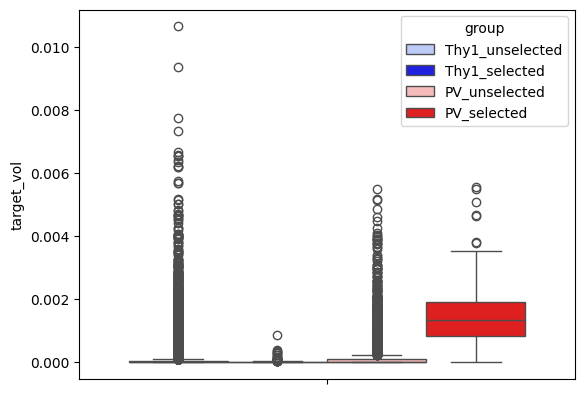

In [29]:
sns.boxplot(data_a4, y="target_vol", hue="group",palette=['#b3c6ff','blue','#ffb3b3','red'])
plt.savefig('./boxplots/SSC_GluA4_vol_boxplot_allgroups.png',dpi=300)

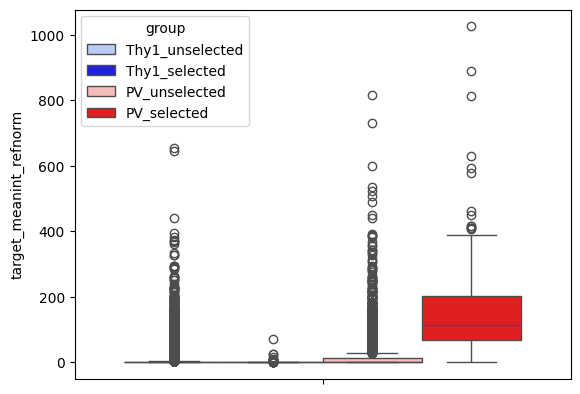

In [30]:
sns.boxplot(data_a4, y="target_meanint_refnorm", hue="group",palette=['#b3c6ff','blue','#ffb3b3','red'])
plt.savefig('./boxplots/SSC_GluA4_meanint_refnorm_boxplot_allgroups.png',dpi=300)

In [31]:
data_a4 = data[data['prot']=='GluA4']
data_a4 = data_a4[data_a4['region']=='CA1']

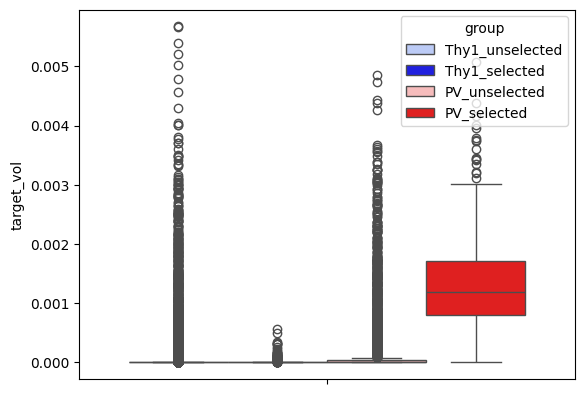

In [32]:
sns.boxplot(data_a4, y="target_vol", hue="group",palette=['#b3c6ff','blue','#ffb3b3','red'])
plt.savefig('./boxplots/CA1_GluA4_vol_boxplot_allgroups.png',dpi=300)

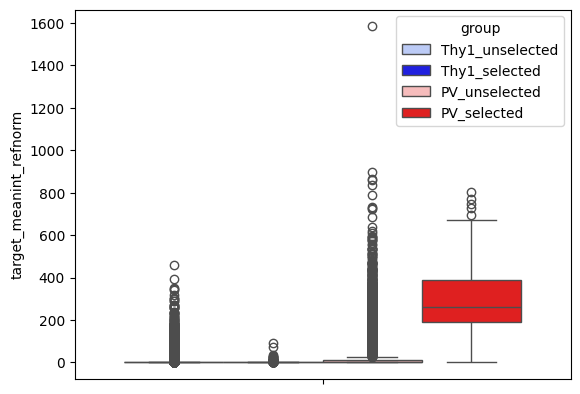

In [33]:
sns.boxplot(data_a4, y="target_meanint_refnorm", hue="group",palette=['#b3c6ff','blue','#ffb3b3','red'])
plt.savefig('./boxplots/CA1_GluA4_meanint_refnorm_boxplot_allgroups.png',dpi=300)

### 2. GluA1

In [34]:
data_a1 = data[data['prot']=='GluA1']
data_a1 = data_a1[data_a1['region']=='SSC']

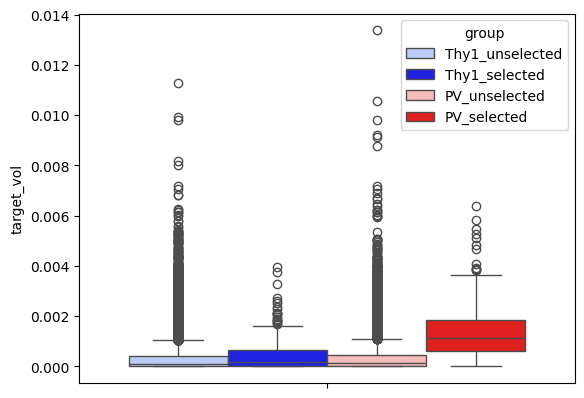

In [35]:
sns.boxplot(data_a1, y="target_vol", hue="group",palette=['#b3c6ff','blue','#ffb3b3','red'])
plt.savefig('./boxplots/SSC_GluA1_vol_boxplot_allgroups.png',dpi=300)

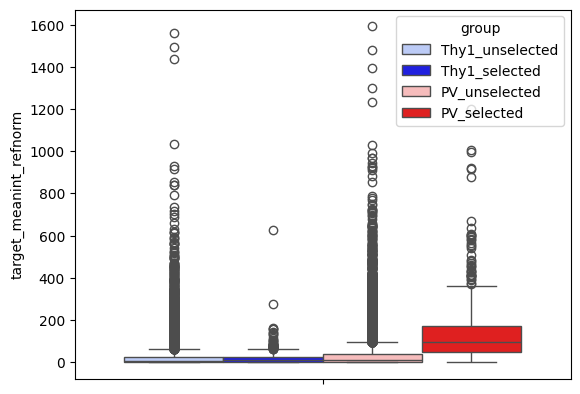

In [36]:
sns.boxplot(data_a1, y="target_meanint_refnorm", hue="group",palette=['#b3c6ff','blue','#ffb3b3','red'])
plt.savefig('./boxplots/SSC_GluA1_meanint_refnorm_boxplot_allgroups.png',dpi=300)

In [37]:
data_a1 = data[data['prot']=='GluA1']
data_a1 = data_a1[data_a1['region']=='CA1']

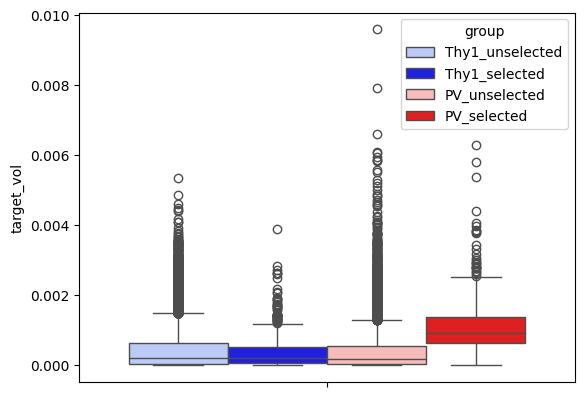

In [38]:
sns.boxplot(data_a1, y="target_vol", hue="group",palette=['#b3c6ff','blue','#ffb3b3','red'])
plt.savefig('./boxplots/CA1_GluA1_vol_boxplot_allgroups.png',dpi=300)

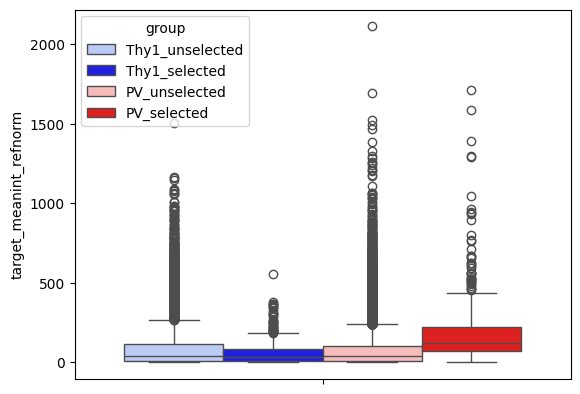

In [39]:
sns.boxplot(data_a1, y="target_meanint_refnorm", hue="group",palette=['#b3c6ff','blue','#ffb3b3','red'])
plt.savefig('./boxplots/CA1_GluA1_meanint_refnorm_boxplot_allgroups.png',dpi=300)

### 3. Stg

In [40]:
data_stg = data[data['prot']=='Stg']
data_stg = data_stg[data_stg['region']=='SSC']

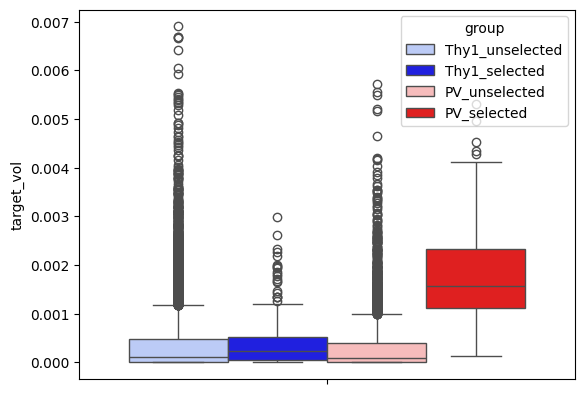

In [41]:
sns.boxplot(data_stg, y="target_vol", hue="group",palette=['#b3c6ff','blue','#ffb3b3','red'])
plt.savefig('./boxplots/SSC_Stg_vol_boxplot_allgroups.png',dpi=300)

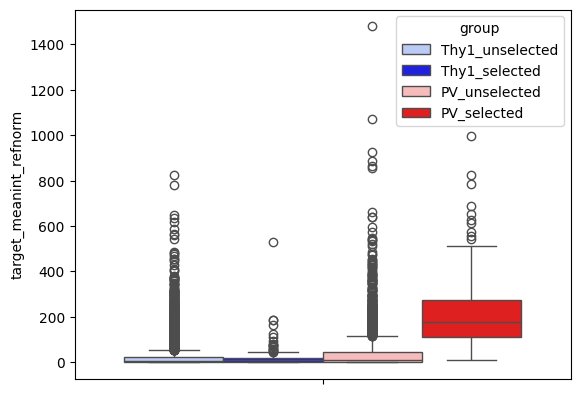

In [42]:
sns.boxplot(data_stg, y="target_meanint_refnorm", hue="group",palette=['#b3c6ff','blue','#ffb3b3','red'])
plt.savefig('./boxplots/SSC_Stg_meanint_refnorm_boxplot_allgroups.png',dpi=300)

In [43]:
data_stg = data[data['prot']=='Stg']
data_stg = data_stg[data_stg['region']=='CA1']

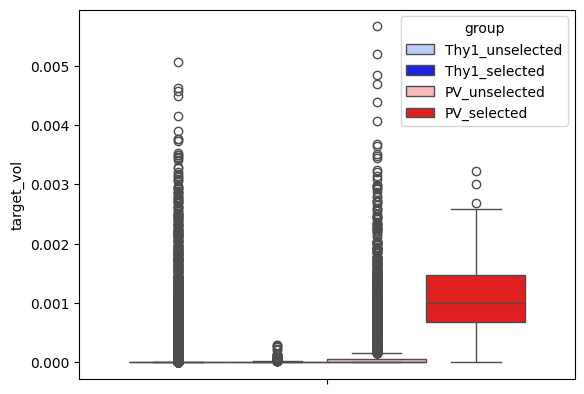

In [44]:
sns.boxplot(data_stg, y="target_vol", hue="group",palette=['#b3c6ff','blue','#ffb3b3','red'])
plt.savefig('./boxplots/CA1_Stg_vol_boxplot_allgroups.png',dpi=300)

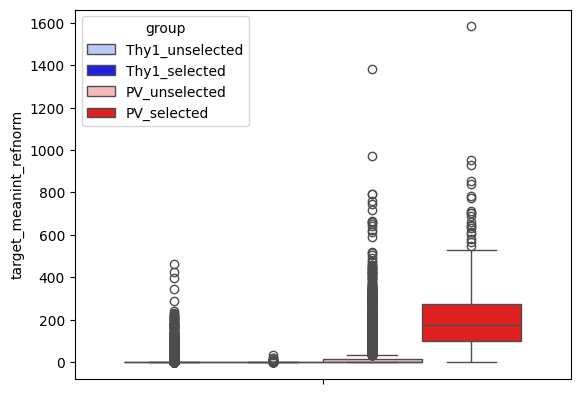

In [45]:
sns.boxplot(data_stg, y="target_meanint_refnorm", hue="group",palette=['#b3c6ff','blue','#ffb3b3','red'])
plt.savefig('./boxplots/CA1_Stg_meanint_refnorm_boxplot_allgroups.png',dpi=300)

### 4. PSD95

In [46]:
data_95 = data[data['prot']=='PSD95']
data_95 = data_95[data_95['region']=='SSC']

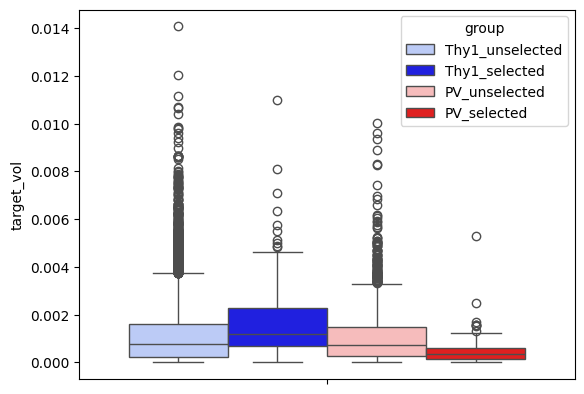

In [47]:
sns.boxplot(data_95, y="target_vol", hue="group",palette=['#b3c6ff','blue','#ffb3b3','red'])
plt.savefig('./boxplots/SSC_PSD95_vol_boxplot_allgroups.png',dpi=300)

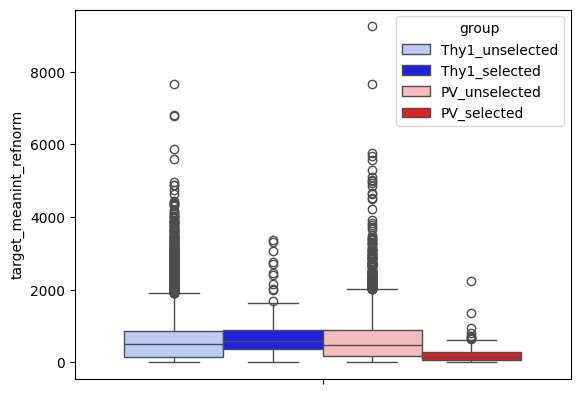

In [48]:
sns.boxplot(data_95, y="target_meanint_refnorm", hue="group",palette=['#b3c6ff','blue','#ffb3b3','red'])
plt.savefig('./boxplots/SSC_PSD95_meanint_refnorm_boxplot_allgroups.png',dpi=300)

In [49]:
data_95 = data[data['prot']=='PSD95']
data_95 = data_95[data_95['region']=='CA1']

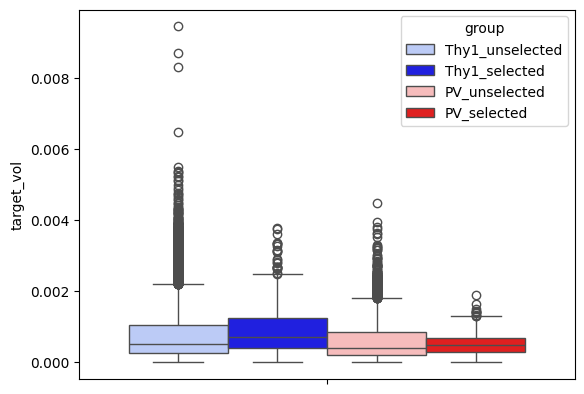

In [50]:
sns.boxplot(data_95, y="target_vol", hue="group",palette=['#b3c6ff','blue','#ffb3b3','red'])
plt.savefig('./boxplots/CA1_PSD95_vol_boxplot_allgroups.png',dpi=300)

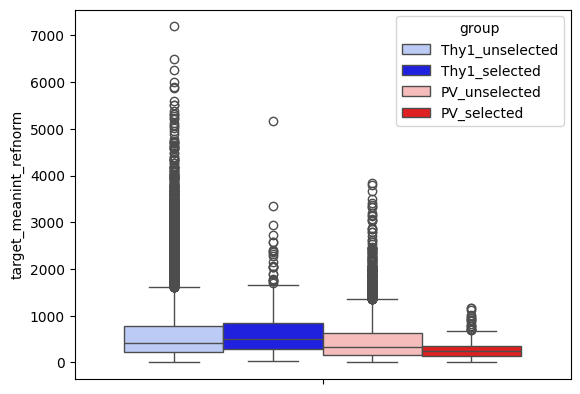

In [51]:
sns.boxplot(data_95, y="target_meanint_refnorm", hue="group",palette=['#b3c6ff','blue','#ffb3b3','red'])
plt.savefig('./boxplots/CA1_PSD95_meanint_refnorm_boxplot_allgroups.png',dpi=300)

### 5. NR1

In [52]:
data_nr1 = data[data['prot']=='NR1']
data_nr1 = data_nr1[data_nr1['region']=='SSC']

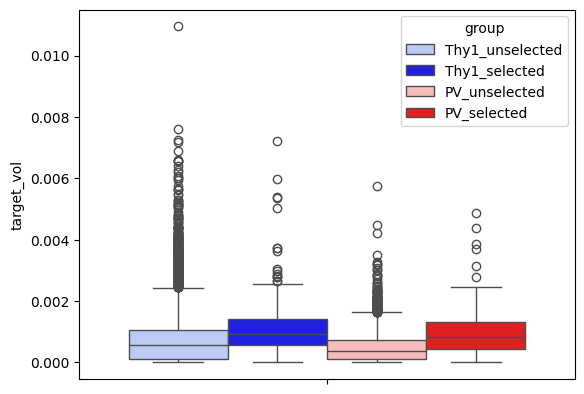

In [53]:
sns.boxplot(data_nr1, y="target_vol", hue="group",palette=['#b3c6ff','blue','#ffb3b3','red'])
plt.savefig('./boxplots/SSC_NR1_vol_boxplot_allgroups.png',dpi=300)

In [54]:
data_nr1['group'].value_counts()

group
Thy1_unselected    11022
PV_unselected       2900
PV_selected          206
Thy1_selected        193
Name: count, dtype: int64

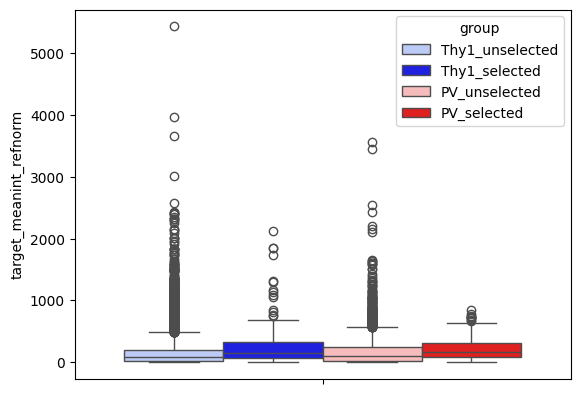

In [55]:
sns.boxplot(data_nr1, y="target_meanint_refnorm", hue="group",palette=['#b3c6ff','blue','#ffb3b3','red'])
plt.savefig('./boxplots/SSC_NR1_meanint_refnorm_boxplot_allgroups.png',dpi=300)

In [56]:
data_nr1 = data[data['prot']=='NR1']
data_nr1 = data_nr1[data_nr1['region']=='CA1']

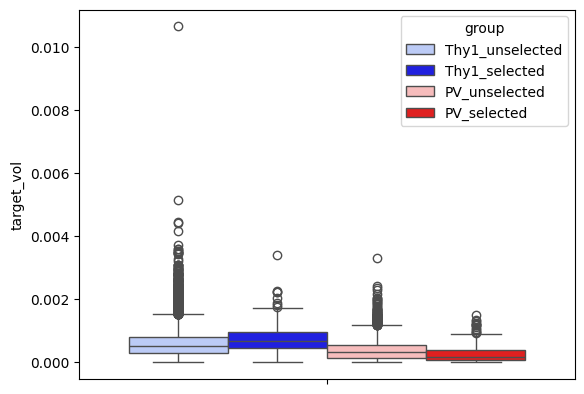

In [57]:
sns.boxplot(data_nr1, y="target_vol", hue="group",palette=['#b3c6ff','blue','#ffb3b3','red'])
plt.savefig('./boxplots/CA1_NR1_vol_boxplot_allgroups.png',dpi=300)

In [58]:
data_nr1['group'].value_counts()

group
Thy1_unselected    28368
PV_unselected       3820
Thy1_selected        423
PV_selected          314
Name: count, dtype: int64

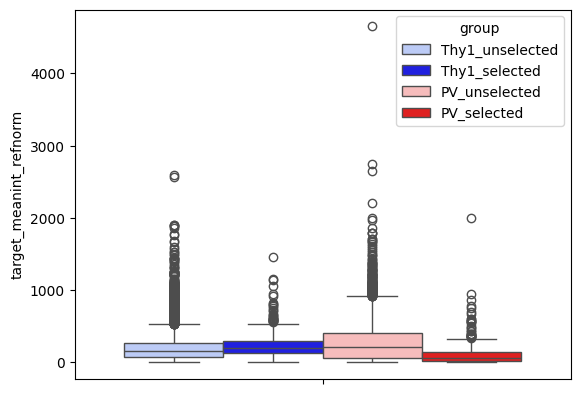

In [59]:
sns.boxplot(data_nr1, y="target_meanint_refnorm", hue="group",palette=['#b3c6ff','blue','#ffb3b3','red'])
plt.savefig('./boxplots/CA1_NR1_meanint_refnorm_boxplot_allgroups.png',dpi=300)

## 3. Test for statistically significant differences in these properties between synapse types

In [60]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

### 1. SSC

In [61]:
unadjusted_pvals = []
zscores = []

In [62]:
data_ctx = data[(data['region']=='SSC')]
data_ctx = data_ctx[(data_ctx['group']=='PV_selected')|(data_ctx['group']=='Thy1_selected')]

In [63]:
data_ctx['group'].value_counts()

group
PV_selected      1398
Thy1_selected    1377
Name: count, dtype: int64

In [64]:
data_ctx['region'].value_counts()

region
SSC    2775
Name: count, dtype: int64

In [65]:
data_ctx['prot'].value_counts()

prot
GluA1    1006
PSD95     472
Stg       454
GluA4     444
NR1       399
Name: count, dtype: int64

#### 1. GluA4

In [66]:
data_ctx_a4 = data_ctx[data_ctx['prot']=='GluA4']

<Axes: ylabel='target_vol'>

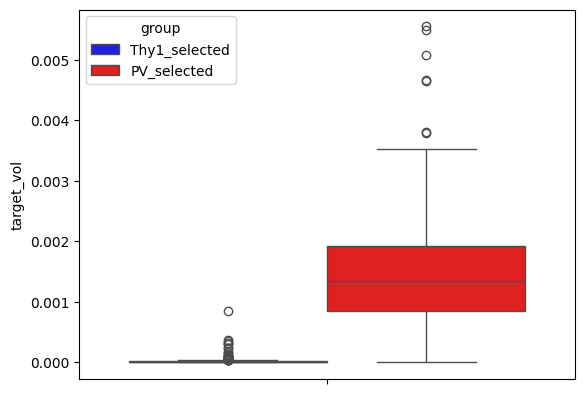

In [67]:
sns.boxplot(data_ctx_a4, y="target_vol", hue="group",palette=['blue','red'])

In [68]:
# Run mixed lm for target
md = smf.mixedlm("target_vol ~ group", data_ctx_a4, groups=data_ctx_a4["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

              Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    target_vol
No. Observations:     444        Method:                REML      
No. Groups:           30         Scale:                 0.0000    
Min. group size:      3          Log-Likelihood:        2574.7517 
Max. group size:      24         Converged:             Yes       
Mean group size:      14.8                                        
------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept               0.002    0.000  17.343 0.000  0.001  0.002
group[T.Thy1_selected] -0.002    0.000 -11.307 0.000 -0.002 -0.001
Group Var               0.000    0.000                            



/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [69]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

2.2329326114452366e-67
1.2054874658954777e-29


In [70]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("target_meanint_refnorm ~ group", data_ctx_a4, groups=data_ctx_a4["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

                 Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  target_meanint_refnorm
No. Observations:  444      Method:              REML                  
No. Groups:        30       Scale:               7742.5447             
Min. group size:   3        Log-Likelihood:      -2639.8376            
Max. group size:   24       Converged:           Yes                   
Mean group size:   14.8                                                
-----------------------------------------------------------------------
                        Coef.   Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------------
Intercept               160.293   16.390  9.780 0.000  128.169  192.416
group[T.Thy1_selected] -158.961   24.370 -6.523 0.000 -206.726 -111.196
Group Var              3776.482   13.613                               



In [71]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

1.3708926699783905e-22
6.90165759940472e-11


#### 1. GluA1

In [72]:
data_ctx_a1 = data_ctx[data_ctx['prot']=='GluA1']

<Axes: ylabel='target_vol'>

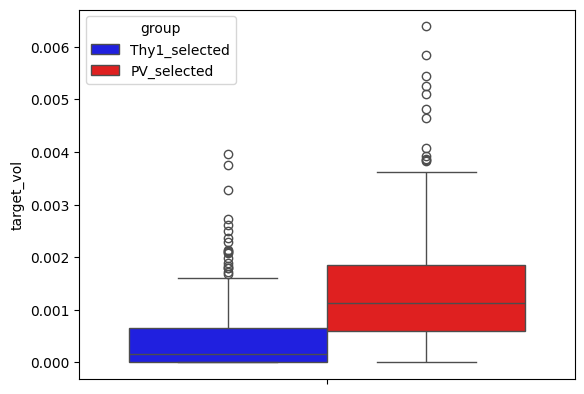

In [73]:
sns.boxplot(data_ctx_a1, y="target_vol", hue="group",palette=['blue','red'])

In [74]:
# Run mixed lm for target
md = smf.mixedlm("target_vol ~ group", data_ctx_a1, groups=data_ctx_a1["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

              Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    target_vol
No. Observations:    1006       Method:                REML      
No. Groups:          48         Scale:                 0.0000    
Min. group size:     6          Log-Likelihood:        5777.3764 
Max. group size:     51         Converged:             Yes       
Mean group size:     21.0                                        
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               0.001    0.000 16.642 0.000  0.001  0.001
group[T.Thy1_selected] -0.001    0.000 -8.372 0.000 -0.001 -0.001
Group Var               0.000    0.000                           



/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [75]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

3.453170276173265e-62
5.688558058281918e-17


In [76]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("target_meanint_refnorm ~ group", data_ctx_a1, groups=data_ctx_a1["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

                Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: target_meanint_refnorm
No. Observations:   1006    Method:             REML                  
No. Groups:         48      Scale:              10260.9593            
Min. group size:    6       Log-Likelihood:     -6108.8228            
Max. group size:    51      Converged:          Yes                   
Mean group size:    21.0                                              
----------------------------------------------------------------------
                        Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
----------------------------------------------------------------------
Intercept               140.838   12.151 11.591 0.000  117.023 164.653
group[T.Thy1_selected] -120.308   16.560 -7.265 0.000 -152.766 -87.851
Group Var              2697.974    6.778                              



In [77]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

4.585793764131631e-31
3.7313061934414817e-13


#### 3. Stg

In [78]:
data_ctx_stg = data_ctx[data_ctx['prot']=='Stg']

<Axes: ylabel='target_vol'>

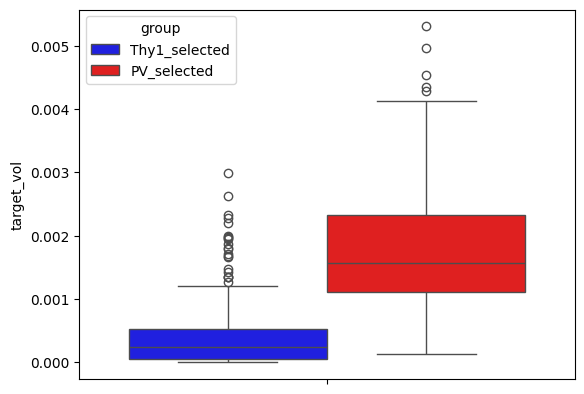

In [79]:
sns.boxplot(data_ctx_stg, y="target_vol", hue="group",palette=['blue','red'])

In [80]:
# Run mixed lm for target
md = smf.mixedlm("target_vol ~ group", data_ctx_stg, groups=data_ctx_stg["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

              Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    target_vol
No. Observations:    454        Method:                REML      
No. Groups:          31         Scale:                 0.0000    
Min. group size:     8          Log-Likelihood:        2599.9278 
Max. group size:     32         Converged:             No        
Mean group size:     14.6                                        
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               0.002    0.000 14.857 0.000  0.002  0.002
group[T.Thy1_selected] -0.001    0.000 -7.705 0.000 -0.002 -0.001
Group Var               0.000    0.000                           



/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 9.505200
  warnings.warn(msg, ConvergenceWarning)
/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [81]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

6.310644720354474e-50
1.3050144573599318e-14


In [82]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("target_meanint_refnorm ~ group", data_ctx_stg, groups=data_ctx_stg["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

                 Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  target_meanint_refnorm
No. Observations:  454      Method:              REML                  
No. Groups:        31       Scale:               9463.8407             
Min. group size:   8        Log-Likelihood:      -2740.9575            
Max. group size:   32       Converged:           Yes                   
Mean group size:   14.6                                                
-----------------------------------------------------------------------
                        Coef.   Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------------
Intercept               222.681   15.714 14.170 0.000  191.881  253.481
group[T.Thy1_selected] -203.435   22.592 -9.005 0.000 -247.715 -159.156
Group Var              3218.883   11.366                               



In [83]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

1.3958546657075885e-45
2.1597224895272447e-19


#### 4. PSD95

In [84]:
data_ctx_95 = data_ctx[data_ctx['prot']=='PSD95']

<Axes: ylabel='target_vol'>

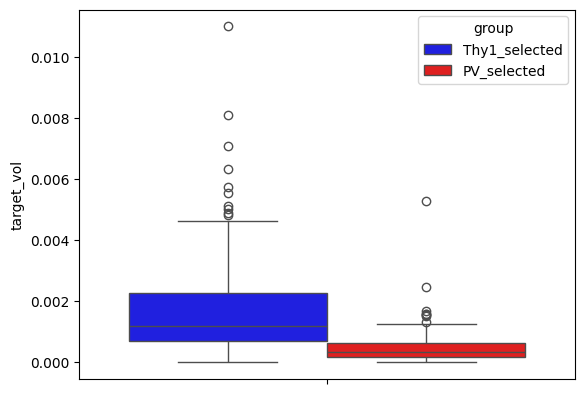

In [85]:
sns.boxplot(data_ctx_95, y="target_vol", hue="group",palette=['blue','red'])

In [86]:
# Run mixed lm for target
md = smf.mixedlm("target_vol ~ group", data_ctx_95, groups=data_ctx_95["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   target_vol
No. Observations:    472       Method:               REML      
No. Groups:          28        Scale:                0.0000    
Min. group size:     9         Log-Likelihood:       2534.2727 
Max. group size:     32        Converged:            Yes       
Mean group size:     16.9                                      
---------------------------------------------------------------
                       Coef. Std.Err.   z   P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept              0.000    0.000 4.681 0.000  0.000  0.001
group[T.Thy1_selected] 0.001    0.000 8.113 0.000  0.001  0.001
Group Var              0.000    0.000                          



/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [87]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

2.8516251924680906e-06
4.9362941656948e-16


In [88]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("target_meanint_refnorm ~ group", data_ctx_95, groups=data_ctx_95["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: target_meanint_refnorm
No. Observations: 472     Method:             REML                  
No. Groups:       28      Scale:              159796.7712           
Min. group size:  9       Log-Likelihood:     -3497.0070            
Max. group size:  32      Converged:          No                    
Mean group size:  16.9                                              
--------------------------------------------------------------------
                        Coef.   Std.Err.   z   P>|z|  [0.025  0.975]
--------------------------------------------------------------------
Intercept               200.454   36.814 5.445 0.000 128.299 272.609
group[T.Thy1_selected]  495.874   53.361 9.293 0.000 391.289 600.460
Group Var              9772.674   11.995                            



/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 9.517068
  warnings.warn(msg, ConvergenceWarning)


In [89]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

5.181255605784519e-08
1.502537906511014e-20


#### 5. NR1

In [90]:
data_ctx_nr1 = data_ctx[data_ctx['prot']=='NR1']

In [91]:
data_ctx_nr1['group'].value_counts()

group
PV_selected      206
Thy1_selected    193
Name: count, dtype: int64

<Axes: ylabel='target_vol'>

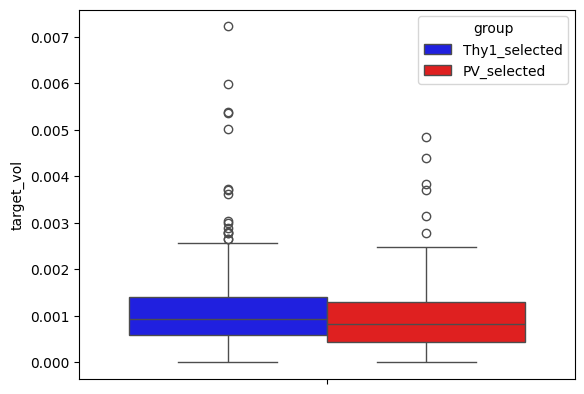

In [92]:
sns.boxplot(data_ctx_nr1, y="target_vol", hue="group",palette=['blue','red'])

In [93]:
# Run mixed lm for target
md = smf.mixedlm("target_vol ~ group", data_ctx_nr1, groups=data_ctx_nr1["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   target_vol
No. Observations:    399       Method:               REML      
No. Groups:          28        Scale:                0.0000    
Min. group size:     2         Log-Likelihood:       2220.7081 
Max. group size:     40        Converged:            Yes       
Mean group size:     14.2                                      
---------------------------------------------------------------
                       Coef. Std.Err.   z   P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept              0.001    0.000 8.734 0.000  0.001  0.001
group[T.Thy1_selected] 0.000    0.000 1.914 0.056 -0.000  0.001
Group Var              0.000    0.000                          



/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [94]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

2.456229903741386e-18
0.05567824473544041


In [95]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("target_meanint_refnorm ~ group", data_ctx_nr1, groups=data_ctx_nr1["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

                Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: target_meanint_refnorm
No. Observations:  399     Method:             REML                  
No. Groups:        28      Scale:              66639.0040            
Min. group size:   2       Log-Likelihood:     -2789.0607            
Max. group size:   40      Converged:          Yes                   
Mean group size:   14.2                                              
---------------------------------------------------------------------
                         Coef.   Std.Err.   z   P>|z|  [0.025  0.975]
---------------------------------------------------------------------
Intercept                234.944   34.507 6.809 0.000 167.311 302.578
group[T.Thy1_selected]    53.840   51.632 1.043 0.297 -47.357 155.038
Group Var              12504.672   21.319                            



In [96]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

9.861754936538941e-12
0.2970587864761447


#### Compile and correct p-values

In [97]:
pvals_df_index = [
    'GluA4_vol',
    'GluA4_meanint_refnorm',
    'GluA1_vol',
    'GluA1_meanint_refnorm',
            'Stg_vol',
    'Stg_meanint_refnorm',
        'PSD95_vol',
    'PSD95_meanint_refnorm',
        'NR1_vol',
    'NR1_meanint_refnorm'
]

In [98]:
pvals_df = pd.DataFrame(unadjusted_pvals,index=pvals_df_index,columns=['p_unadjusted'])

In [99]:
pvals_df['zscore_unselected'] = zscores

In [100]:
pvals_df['p_adjusted'] = stats.false_discovery_control(pvals_df['p_unadjusted'])
pvals_df['significant'] = pvals_df['p_adjusted'] < 0.05
pvals_df.to_csv('ssc_selectedvsunselected_lmer_pvals.csv')

In [101]:
prots = unique(data['prot'])
values = ['target_vol','target_meanint_refnorm']
group_colors = ['blue','red']

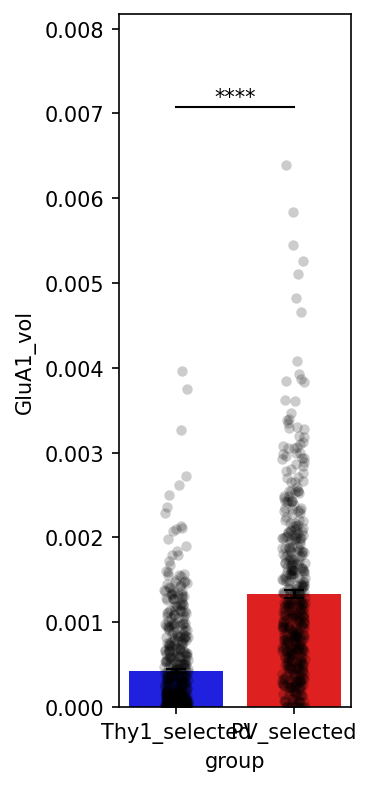

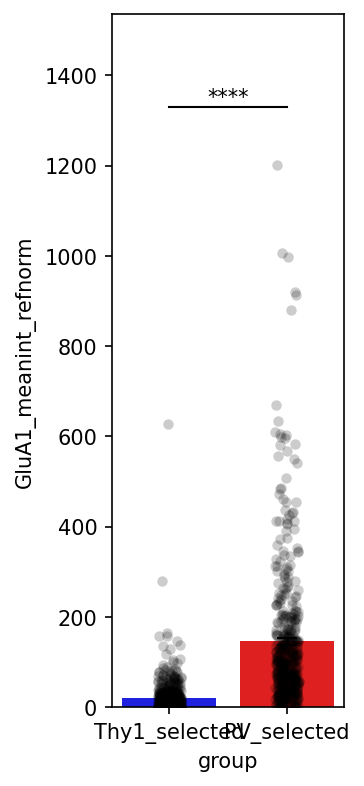

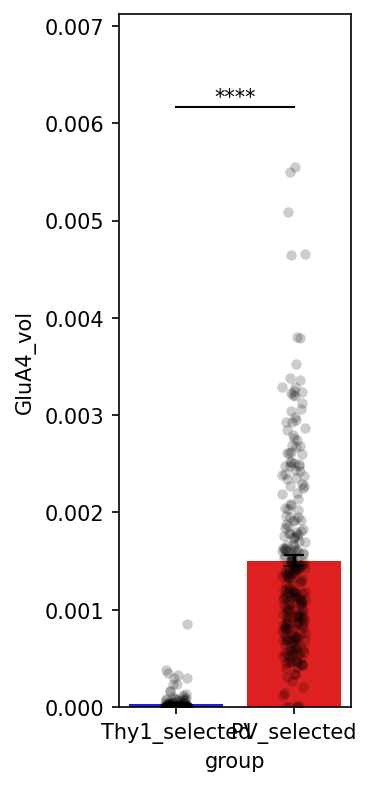

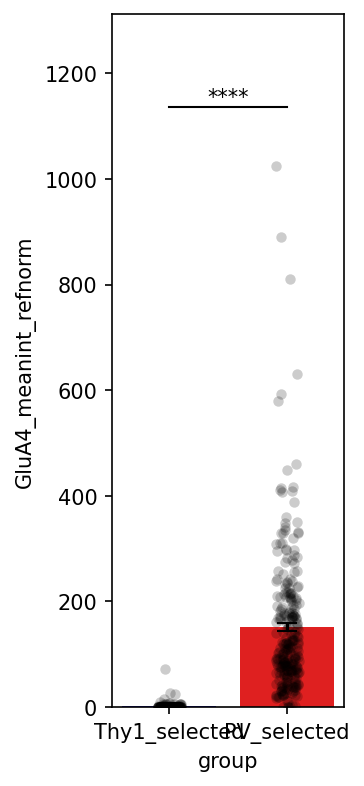

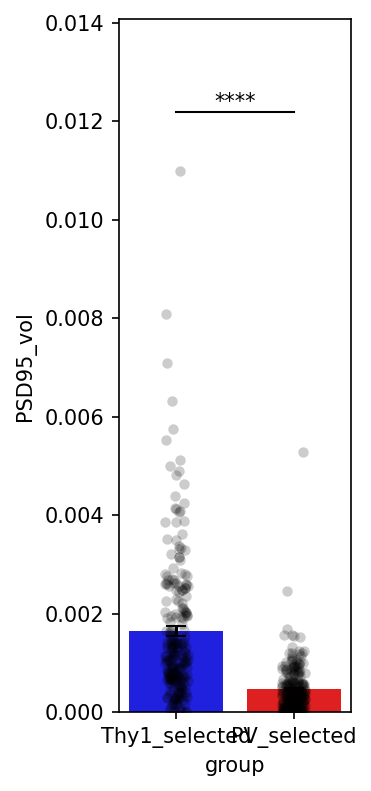

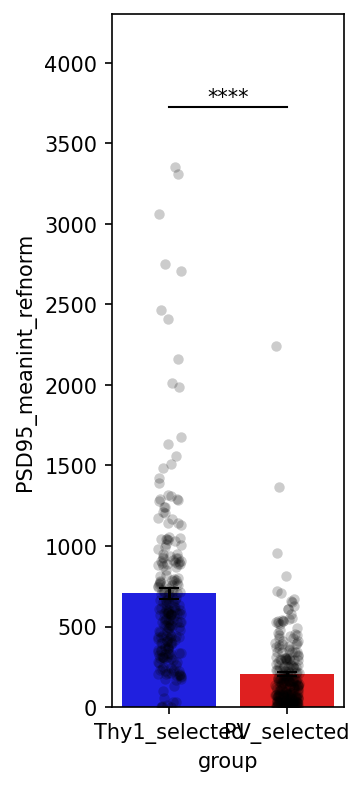

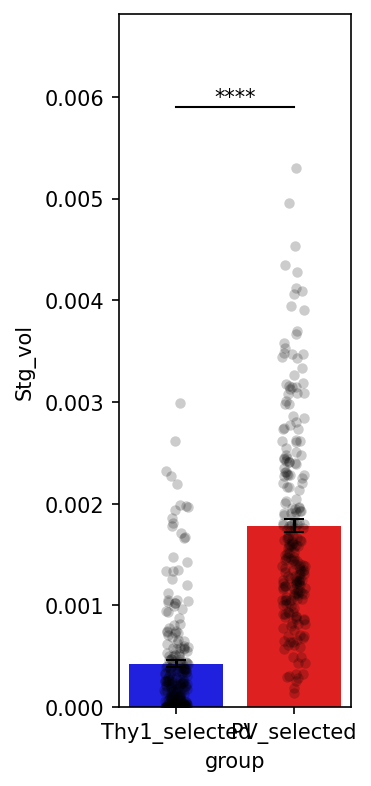

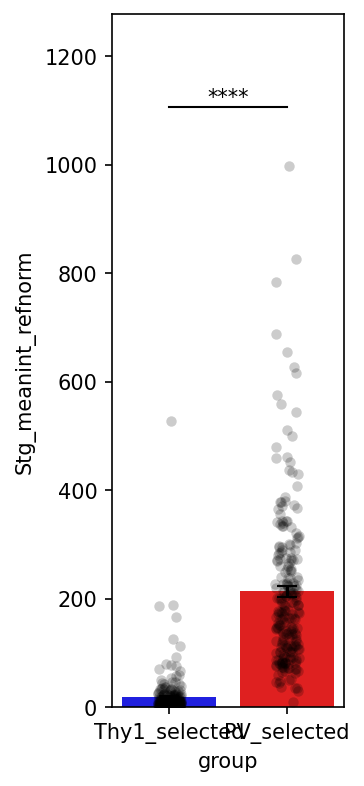

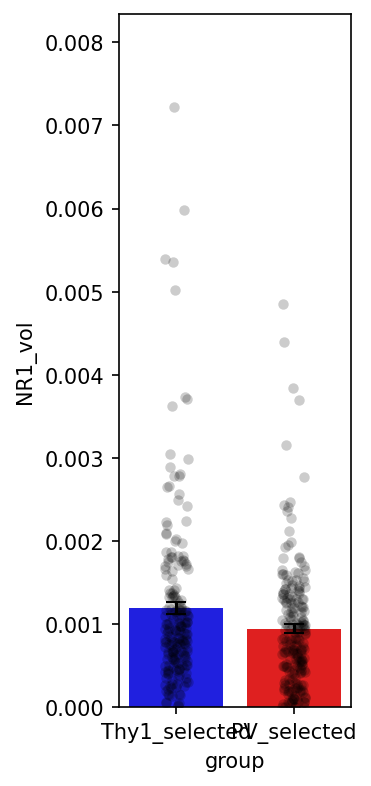

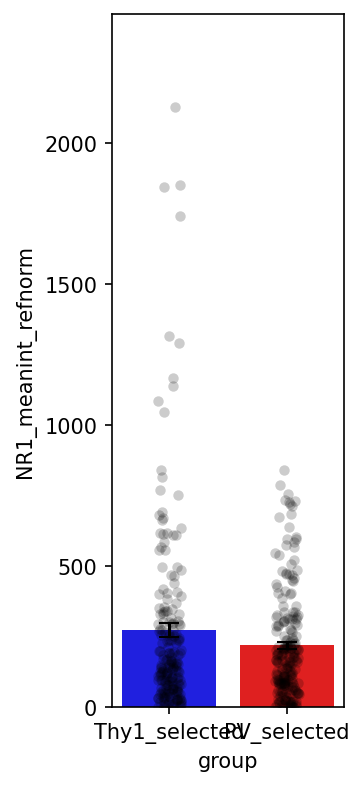

In [102]:
# Code generated by ChatGPT (4.0) on 6/9/24 by MES, also modified by MES

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Assuming your data_ctxFrame with data_ctx is named 'data_ctx'
# and the data frame with significance information is named 'pvals_df'
# pvals_df should have an index matching the numerical variable names in 'data_ctx'

# Example data_ctxFrames (uncomment and adjust according to your actual data_ctx)
# data_ctx = pd.read_csv('your_data_ctx.csv')
# pvals_df = pd.read_csv('your_significance_data_ctx.csv')

# Identify numerical columns in 'data_ctx'
numerical_columns = data_ctx.select_dtypes(include='number').columns

# Get unique values of 'group'
types = data_ctx['group'].unique()

# Function to calculate SEM
def sem(x):
    return stats.sem(x, nan_policy='omit')

# Function to determine the number of asterisks based on p-value
def get_significance_asterisks(p_value):
    if p_value < 0.0001:
        return '****'
    elif p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return ''

# Create bar plots for each numerical variable
for prot in prots:
    for col in values:
        data_temp = data_ctx[data_ctx['prot']==prot]
        plt.figure(figsize=(2,6),dpi=150)
        ax = sns.barplot(x='group', y=col, data=data_temp, ci=None, palette=group_colors)  # Suppress default error bars
        
        # Add individual data_ctx points
        sns.stripplot(x='group', y=col, data=data_temp, color='black', size=5, jitter=True, ax=ax, alpha = 0.2)
        
        # Calculate and plot error bars (mean ± SEM)
        means = data_temp.groupby('group')[col].mean()
        sems = data_temp.groupby('group')[col].apply(sem)
        for i, type_val in enumerate(types):
           plt.errorbar(i, means[type_val], yerr=sems[type_val], fmt='none', c='black', capsize=5)
    
        # Add significance asterisks if applicable
        if len(col.split("_")) > 2:
            value_name = prot + '_' + col.split("_")[1] + '_' + col.split("_")[2]
        else:
            value_name = prot + '_' + col.split("_")[1]
        
        if value_name in pvals_df.index and pvals_df.loc[value_name, 'significant'] == True:
            p_value = pvals_df.loc[value_name, 'p_adjusted']
            asterisks = get_significance_asterisks(p_value)
            if asterisks:
                max_y = data_temp[col].max()
                # Position the asterisks above the highest data_temp point
                y = max_y + sems.max() + 0.1 * max_y
                plt.plot([0, 1], [y, y], color='black', lw=1)  # horizontal line
                plt.text(0.5, y, asterisks, ha='center', va='bottom', color='black')
    
        # Adjust y-axis to add space for asterisks
        current_ylim = plt.ylim()
        plt.ylim(current_ylim[0], current_ylim[1] * 1.1)
    
        plt.grid(False) #remove gridlines
        
        # Set plot title and labels
        # plt.title(f'Bar Plot for {col}')
        #plt.xlabel('Group')
        plt.ylabel(value_name)
    
        # Save plot
        plt.savefig(parentdir + '/SSC_barplots/' + col + '_' + prot + '.svg',dpi=800,bbox_inches='tight')
        plt.savefig(parentdir + '/SSC_barplots/' + col + '_' + prot + '.png',dpi=800,bbox_inches='tight')
        
        # Show plot
        plt.show()

### 2. CA1

In [103]:
unadjusted_pvals = []
zscores = []

In [104]:
data_ca1 = data[(data['region']=='CA1')]
data_ca1 = data_ca1[(data_ca1['group']=='PV_selected')|(data_ca1['group']=='Thy1_selected')]

In [105]:
data_ca1['group'].value_counts()

group
Thy1_selected    2253
PV_selected      1907
Name: count, dtype: int64

In [106]:
data_ca1['region'].value_counts()

region
CA1    4160
Name: count, dtype: int64

In [107]:
data_ca1['prot'].value_counts()

prot
GluA1    997
PSD95    954
GluA4    737
NR1      737
Stg      735
Name: count, dtype: int64

#### 1. GluA4

In [108]:
data_ca1_a4 = data_ca1[data_ca1['prot']=='GluA4']

In [109]:
# Run mixed lm for target
md = smf.mixedlm("target_vol ~ group", data_ca1_a4, groups=data_ca1_a4["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

              Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    target_vol
No. Observations:     737        Method:                REML      
No. Groups:           34         Scale:                 0.0000    
Min. group size:      6          Log-Likelihood:        4476.3847 
Max. group size:      39         Converged:             Yes       
Mean group size:      21.7                                        
------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept               0.001    0.000  19.081 0.000  0.001  0.002
group[T.Thy1_selected] -0.001    0.000 -13.948 0.000 -0.002 -0.001
Group Var               0.000    0.000                            



/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [110]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

3.643050809270621e-81
3.2381441441338627e-44


In [111]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("target_meanint_refnorm ~ group", data_ca1_a4, groups=data_ca1_a4["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

                 Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  target_meanint_refnorm
No. Observations:   737      Method:              REML                  
No. Groups:         34       Scale:               10566.6998            
Min. group size:    6        Log-Likelihood:      -4472.0936            
Max. group size:    39       Converged:           Yes                   
Mean group size:    21.7                                                
------------------------------------------------------------------------
                        Coef.   Std.Err.    z    P>|z|  [0.025   0.975] 
------------------------------------------------------------------------
Intercept               291.961   10.159  28.740 0.000  272.050  311.872
group[T.Thy1_selected] -290.332   13.778 -21.071 0.000 -317.337 -263.326
Group Var              1075.905    3.850                                



In [112]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

1.218650258846804e-181
1.4530267086784393e-98


#### 2. GluA1

In [113]:
data_ca1_a1 = data_ca1[data_ca1['prot']=='GluA4']

In [114]:
# Run mixed lm for target
md = smf.mixedlm("target_vol ~ group", data_ca1_a1, groups=data_ca1_a1["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

              Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    target_vol
No. Observations:     737        Method:                REML      
No. Groups:           34         Scale:                 0.0000    
Min. group size:      6          Log-Likelihood:        4476.3847 
Max. group size:      39         Converged:             Yes       
Mean group size:      21.7                                        
------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept               0.001    0.000  19.081 0.000  0.001  0.002
group[T.Thy1_selected] -0.001    0.000 -13.948 0.000 -0.002 -0.001
Group Var               0.000    0.000                            



/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [115]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

3.643050809270621e-81
3.2381441441338627e-44


In [116]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("target_meanint_refnorm ~ group", data_ca1_a1, groups=data_ca1_a1["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

                 Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  target_meanint_refnorm
No. Observations:   737      Method:              REML                  
No. Groups:         34       Scale:               10566.6998            
Min. group size:    6        Log-Likelihood:      -4472.0936            
Max. group size:    39       Converged:           Yes                   
Mean group size:    21.7                                                
------------------------------------------------------------------------
                        Coef.   Std.Err.    z    P>|z|  [0.025   0.975] 
------------------------------------------------------------------------
Intercept               291.961   10.159  28.740 0.000  272.050  311.872
group[T.Thy1_selected] -290.332   13.778 -21.071 0.000 -317.337 -263.326
Group Var              1075.905    3.850                                



In [117]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

1.218650258846804e-181
1.4530267086784393e-98


#### 3. Stg

In [118]:
data_ca1_stg = data_ca1[data_ca1['prot']=='Stg']

In [119]:
# Run mixed lm for target
md = smf.mixedlm("target_vol ~ group", data_ca1_stg, groups=data_ca1_stg["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

              Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    target_vol
No. Observations:     735        Method:                REML      
No. Groups:           33         Scale:                 0.0000    
Min. group size:      10         Log-Likelihood:        4690.9101 
Max. group size:      41         Converged:             Yes       
Mean group size:      22.3                                        
------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept               0.001    0.000  25.290 0.000  0.001  0.001
group[T.Thy1_selected] -0.001    0.000 -17.755 0.000 -0.001 -0.001
Group Var               0.000    0.000                            



/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [120]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

4.148676910716152e-141
1.582694652668209e-70


In [121]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("target_meanint_refnorm ~ group", data_ca1_stg, groups=data_ca1_stg["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

                 Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  target_meanint_refnorm
No. Observations:  735      Method:              REML                  
No. Groups:        33       Scale:               10695.9735            
Min. group size:   10       Log-Likelihood:      -4485.9318            
Max. group size:   41       Converged:           Yes                   
Mean group size:   22.3                                                
-----------------------------------------------------------------------
                        Coef.   Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------------
Intercept               211.393   20.254 10.437 0.000  171.697  251.089
group[T.Thy1_selected] -210.555   28.300 -7.440 0.000 -266.022 -155.087
Group Var              6068.025   16.605                               



In [122]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

1.6739203294580958e-25
1.0067659597347279e-13


#### 4. PSD95

In [123]:
data_ca1_95 = data_ca1[data_ca1['prot']=='PSD95']

In [124]:
# Run mixed lm for target
md = smf.mixedlm("target_vol ~ group", data_ca1_95, groups=data_ca1_95["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   target_vol
No. Observations:    954       Method:               REML      
No. Groups:          34        Scale:                0.0000    
Min. group size:     8         Log-Likelihood:       5752.0317 
Max. group size:     50        Converged:            Yes       
Mean group size:     28.1                                      
---------------------------------------------------------------
                       Coef. Std.Err.   z   P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept              0.001    0.000 9.970 0.000  0.000  0.001
group[T.Thy1_selected] 0.000    0.000 5.963 0.000  0.000  0.001
Group Var              0.000    0.000                          



/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [125]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

2.072476879654337e-23
2.4710060073827604e-09


In [126]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("target_meanint_refnorm ~ group", data_ca1_95, groups=data_ca1_95["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

                Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: target_meanint_refnorm
No. Observations:  954     Method:             REML                  
No. Groups:        34      Scale:              160753.9994           
Min. group size:   8       Log-Likelihood:     -7090.0459            
Max. group size:   50      Converged:          Yes                   
Mean group size:   28.1                                              
---------------------------------------------------------------------
                         Coef.   Std.Err.   z   P>|z|  [0.025  0.975]
---------------------------------------------------------------------
Intercept                261.656   47.601 5.497 0.000 168.360 354.953
group[T.Thy1_selected]   400.913   63.232 6.340 0.000 276.980 524.846
Group Var              26669.227   23.705                            



In [127]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

3.866803185407916e-08
2.2927252073909752e-10


#### 5. NR1

In [128]:
data_ca1_nr1 = data_ca1[data_ca1['prot']=='NR1']

In [129]:
data_ca1_nr1

,target_vol,target_meanint,target_meanint_refnorm,target_npuncta,selected_tf,sample,region,roi_full,fov,syn,prot,group,GFP_tag
filename,,,,,,,,,,,,,
Thy1GFP_CA1_NR1_M1_000_fov001_pp_syn15,0.001151,339.430220,98.053046,1.0,1.0,M1,CA1,Thy1-CA1-M1-NR1-fov001,fov001,syn15,NR1,Thy1_selected,Thy1
Thy1GFP_CA1_NR1_M1_000_fov001_pp_syn179,0.000630,351.145594,286.851330,1.0,1.0,M1,CA1,Thy1-CA1-M1-NR1-fov001,fov001,syn179,NR1,Thy1_selected,Thy1
Thy1GFP_CA1_NR1_M1_000_fov001_pp_syn283,0.001310,495.079263,265.002960,2.0,1.0,M1,CA1,Thy1-CA1-M1-NR1-fov001,fov001,syn283,NR1,Thy1_selected,Thy1
Thy1GFP_CA1_NR1_M1_000_fov001_pp_syn336,0.000883,390.688098,196.149038,1.0,1.0,M1,CA1,Thy1-CA1-M1-NR1-fov001,fov001,syn336,NR1,Thy1_selected,Thy1
Thy1GFP_CA1_NR1_M1_000_fov001_pp_syn338,0.001294,428.388060,244.532481,1.0,1.0,M1,CA1,Thy1-CA1-M1-NR1-fov001,fov001,syn338,NR1,Thy1_selected,Thy1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
CA1_33-2-8_NR1_fov105_crop50(6-55)_pp_syn219,0.000241,686.295000,145.401483,1.0,1.0,33-2-8,CA1,PV-CA1-33-2-8-NR1-fov105,fov105,syn219,NR1,PV_selected,PV
CA1_33-2-8_NR1_fov105_crop50(6-55)_pp_syn224,0.000295,791.938525,71.673961,2.0,1.0,33-2-8,CA1,PV-CA1-33-2-8-NR1-fov105,fov105,syn224,NR1,PV_selected,PV
CA1_33-2-8_NR1_fov105_crop50(6-55)_pp_syn225,0.000171,756.647887,64.492197,2.0,1.0,33-2-8,CA1,PV-CA1-33-2-8-NR1-fov105,fov105,syn225,NR1,PV_selected,PV


In [130]:
# Run mixed lm for target
md = smf.mixedlm("target_vol ~ group", data_ca1_nr1, groups=data_ca1_nr1["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   target_vol
No. Observations:    737       Method:               REML      
No. Groups:          34        Scale:                0.0000    
Min. group size:     10        Log-Likelihood:       4823.5729 
Max. group size:     38        Converged:            Yes       
Mean group size:     21.7                                      
---------------------------------------------------------------
                       Coef. Std.Err.   z   P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept              0.000    0.000 6.592 0.000  0.000  0.000
group[T.Thy1_selected] 0.000    0.000 8.596 0.000  0.000  0.001
Group Var              0.000    0.000                          



/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [131]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

4.3442865052701286e-11
8.244053540375364e-18


In [132]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("target_meanint_refnorm ~ group", data_ca1_nr1, groups=data_ca1_nr1["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: target_meanint_refnorm
No. Observations: 737     Method:             REML                  
No. Groups:       34      Scale:              27681.0292            
Min. group size:  10      Log-Likelihood:     -4835.8959            
Max. group size:  38      Converged:          Yes                   
Mean group size:  21.7                                              
--------------------------------------------------------------------
                         Coef.   Std.Err.   z   P>|z| [0.025  0.975]
--------------------------------------------------------------------
Intercept                112.632   22.962 4.905 0.000 67.628 157.637
group[T.Thy1_selected]   125.280   30.753 4.074 0.000 65.005 185.554
Group Var               6503.027   11.967                           



In [133]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

9.332842462979364e-07
4.626189815414462e-05


#### Compile and correct p-values

In [134]:
pvals_df_index = [
    'GluA4_vol',
    'GluA4_meanint_refnorm',
    'GluA1_vol',
    'GluA1_meanint_refnorm',
            'Stg_vol',
    'Stg_meanint_refnorm',
        'PSD95_vol',
    'PSD95_meanint_refnorm',
        'NR1_vol',
    'NR1_meanint_refnorm'
]

In [135]:
pvals_df = pd.DataFrame(unadjusted_pvals,index=pvals_df_index,columns=['p_unadjusted'])

In [136]:
pvals_df['zscore_unselected'] = zscores

In [137]:
pvals_df['p_adjusted'] = stats.false_discovery_control(pvals_df['p_unadjusted'])
pvals_df['significant'] = pvals_df['p_adjusted'] < 0.05
pvals_df.to_csv('ca1_selectedvsunselected_lmer_pvals.csv')

In [138]:
prots = unique(data['prot'])
values = ['target_vol','target_meanint_refnorm']

In [139]:
prots

['GluA1', 'GluA4', 'PSD95', 'Stg', 'NR1']

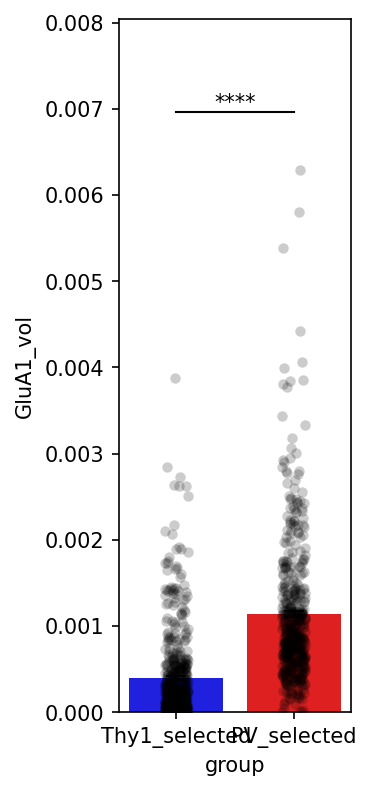

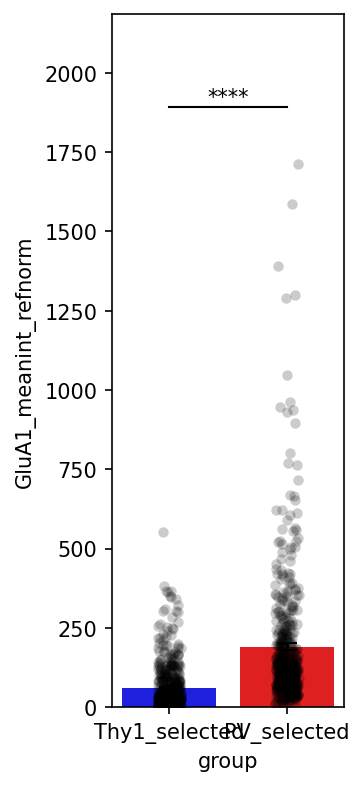

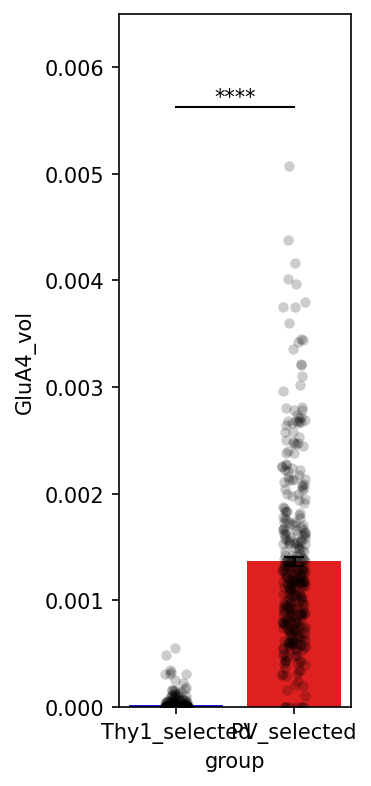

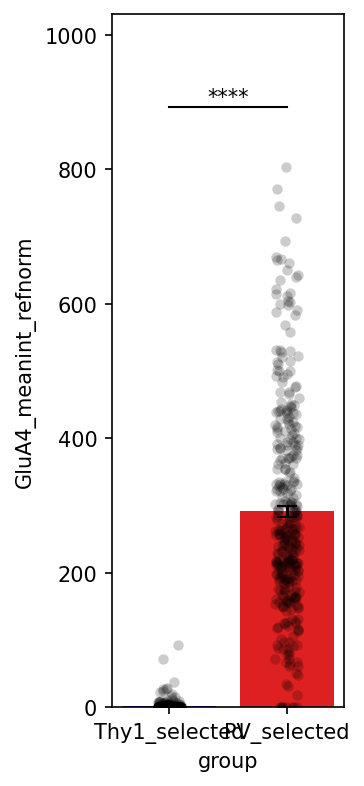

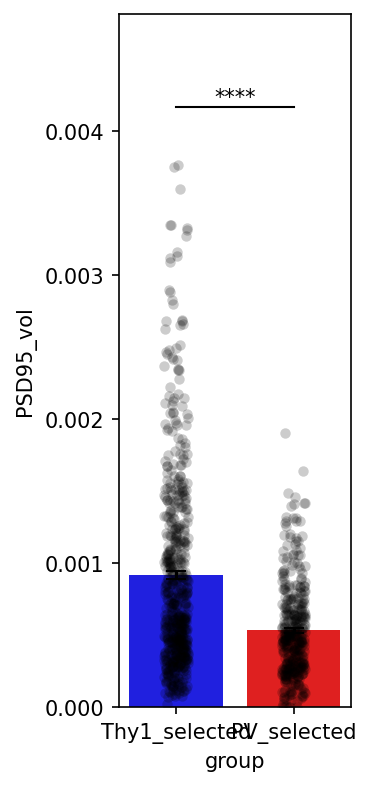

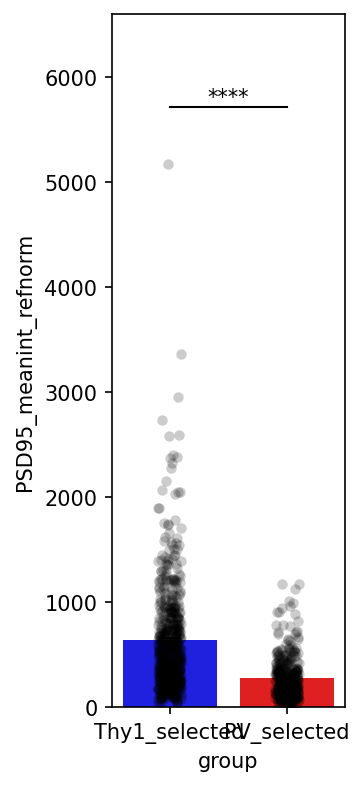

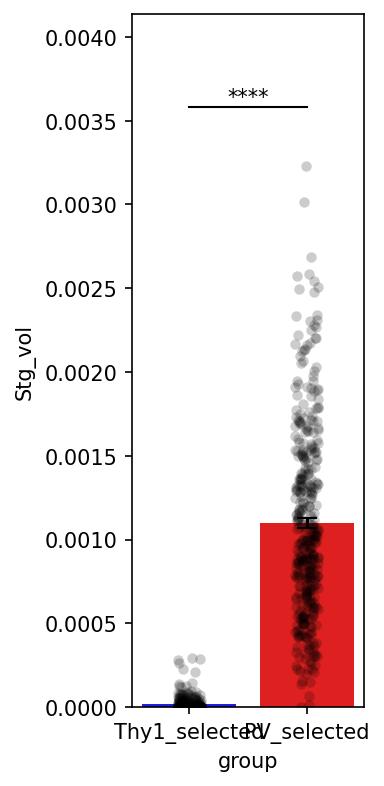

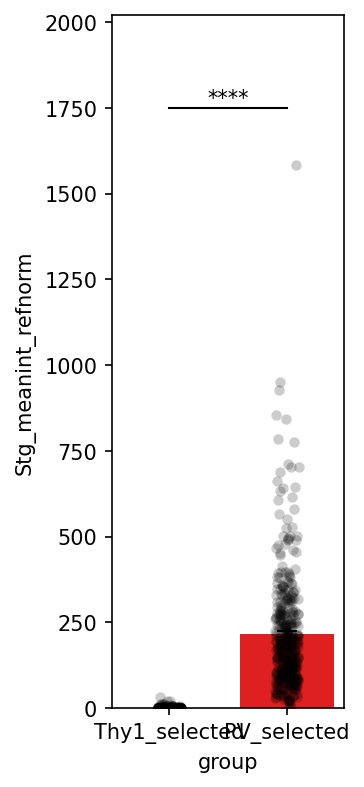

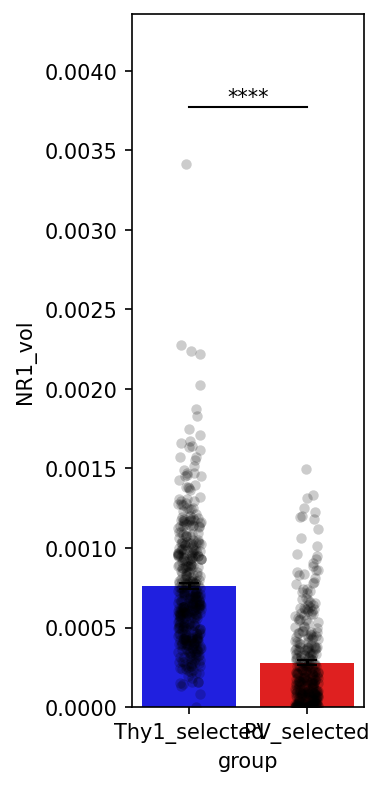

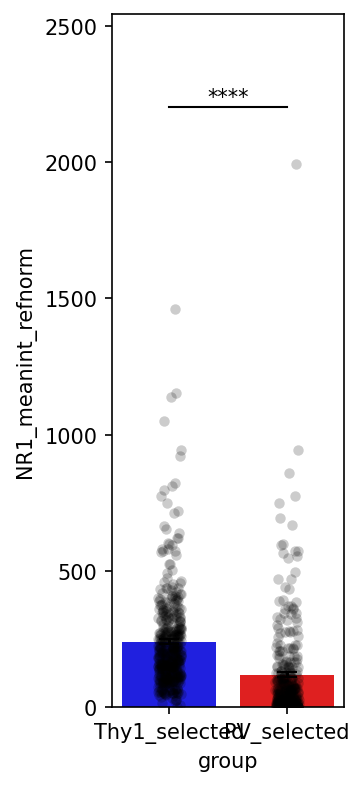

In [140]:
# Code generated by ChatGPT (4.0) on 6/9/24 by MES, also modified by MES

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Assuming your data_ctxFrame with data_ctx is named 'data_ctx'
# and the data frame with significance information is named 'pvals_df'
# pvals_df should have an index matching the numerical variable names in 'data_ctx'

# Example data_ctxFrames (uncomment and adjust according to your actual data_ctx)
# data_ctx = pd.read_csv('your_data_ctx.csv')
# pvals_df = pd.read_csv('your_significance_data_ctx.csv')

# Identify numerical columns in 'data_ctx'
numerical_columns = data_ctx.select_dtypes(include='number').columns

# Get unique values of 'group'
types = data_ctx['group'].unique()

# Function to calculate SEM
def sem(x):
    return stats.sem(x, nan_policy='omit')

# Function to determine the number of asterisks based on p-value
def get_significance_asterisks(p_value):
    if p_value < 0.0001:
        return '****'
    elif p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return ''

# Create bar plots for each numerical variable
for prot in prots:
    for col in values:
        data_temp = data_ca1[data_ca1['prot']==prot]
        plt.figure(figsize=(2,6),dpi=150)
        ax = sns.barplot(x='group', y=col, data=data_temp, ci=None, palette=group_colors)  # Suppress default error bars
        
        # Add individual data_ctx points
        sns.stripplot(x='group', y=col, data=data_temp, color='black', size=5, jitter=True, ax=ax, alpha = 0.2)
        
        # Calculate and plot error bars (mean ± SEM)
        means = data_temp.groupby('group')[col].mean()
        sems = data_temp.groupby('group')[col].apply(sem)
        for i, type_val in enumerate(types):
           plt.errorbar(i, means[type_val], yerr=sems[type_val], fmt='none', c='black', capsize=5)
    
        # Add significance asterisks if applicable
        if len(col.split("_")) > 2:
            value_name = prot + '_' + col.split("_")[1] + '_' + col.split("_")[2]
        else:
            value_name = prot + '_' + col.split("_")[1]
        
        if value_name in pvals_df.index and pvals_df.loc[value_name, 'significant'] == True:
            p_value = pvals_df.loc[value_name, 'p_adjusted']
            asterisks = get_significance_asterisks(p_value)
            if asterisks:
                max_y = data_temp[col].max()
                # Position the asterisks above the highest data_temp point
                y = max_y + sems.max() + 0.1 * max_y
                plt.plot([0, 1], [y, y], color='black', lw=1)  # horizontal line
                plt.text(0.5, y, asterisks, ha='center', va='bottom', color='black')
    
        # Adjust y-axis to add space for asterisks
        current_ylim = plt.ylim()
        plt.ylim(current_ylim[0], current_ylim[1] * 1.1)
    
        plt.grid(False) #remove gridlines
        
        # Set plot title and labels
        # plt.title(f'Bar Plot for {col}')
        #plt.xlabel('Group')
        plt.ylabel(value_name)
    
        # Save plot
        plt.savefig(parentdir + 'CA1_barplots/' + col + '_' + prot + '.svg',dpi=800,bbox_inches='tight')
        plt.savefig(parentdir + 'CA1_barplots/' + col + '_' + prot + '.png',dpi=800,bbox_inches='tight')
        
        # Show plot
        plt.show()

In [141]:
#save down combined data
data.to_csv('/Users/margaret/Dropbox (MIT)/mExR_analysis/SmallData/multiExR_PV_synapses/PV_vs_Thy1_combined/Thy1_vs_PV_alldata_combined.csv')

## Now try normalizing measures on a per-field of view basis

In [142]:
data_selected = data[(data['group']=='PV_selected')|(data['group']=='Thy1_selected')]

In [143]:
data_selected.shape

(6935, 13)

In [144]:
data_unselected = data[(data['group']=='PV_unselected')|(data['group']=='Thy1_unselected')]

In [145]:
data_unselected.shape

(299873, 13)

In [146]:
data.shape

(306808, 13)

In [147]:
vol_mean = pd.DataFrame(data_unselected.groupby(['roi_full'])['target_vol'].mean())
meanint_mean = pd.DataFrame(data_unselected.groupby(['roi_full'])['target_meanint'].mean())
meanint_refnorm_mean = pd.DataFrame(data_unselected.groupby(['roi_full'])['target_meanint_refnorm'].mean())

In [148]:
data_uns_mean = pd.concat((vol_mean,meanint_mean,meanint_refnorm_mean),axis=1)

In [149]:
vol_mean = pd.DataFrame(data_selected.groupby(['roi_full'])['target_vol'].mean())
meanint_mean = pd.DataFrame(data_selected.groupby(['roi_full'])['target_meanint'].mean())
meanint_refnorm_mean = pd.DataFrame(data_selected.groupby(['roi_full'])['target_meanint_refnorm'].mean())

In [150]:
data_sel_mean = pd.concat((vol_mean,meanint_mean,meanint_refnorm_mean),axis=1)

In [151]:
data_sel_mean.shape[0] == data_uns_mean.shape[0]

True

In [152]:
data[data['roi_full']=='Thy1-SSC-M1-NR1-fov006']['target_vol'].sum()

0.48880266104472375

In [153]:
data[data['roi_full']=='Thy1-SSC-M1-NR1-fov006']['target_vol'].mean()

0.0007697679701491713

In [154]:
data[data['roi_full']=='Thy1-SSC-M1-NR1-fov006']['target_meanint_refnorm'].sum()

84493.22640232898

In [155]:
data[data['roi_full']=='Thy1-SSC-M1-NR1-fov006']['target_meanint_refnorm'].mean()

133.0601990587858

In [156]:
data_sel_mean.loc['Thy1-SSC-M1-NR1-fov006']

target_vol                  0.001722
target_meanint            443.048370
target_meanint_refnorm    400.277829
Name: Thy1-SSC-M1-NR1-fov006, dtype: float64

In [157]:
data_sel_mean.loc['Thy1-SSC-M1-NR1-fov001']

target_vol                  0.001070
target_meanint            377.872055
target_meanint_refnorm     97.679548
Name: Thy1-SSC-M1-NR1-fov001, dtype: float64

In [158]:
data_uns_mean.loc['Thy1-SSC-M1-NR1-fov001']

target_vol                  0.000871
target_meanint            309.583690
target_meanint_refnorm    127.649456
Name: Thy1-SSC-M1-NR1-fov001, dtype: float64

In [159]:
data_uns_mean.loc['Thy1-SSC-M1-NR1-fov006']

target_vol                  0.000761
target_meanint            296.478476
target_meanint_refnorm    130.511223
Name: Thy1-SSC-M1-NR1-fov006, dtype: float64

In [160]:
data_norm_mean = data_sel_mean/data_uns_mean

In [161]:
len(unique(data['roi_full']))

345

In [162]:
data_norm_mean

,target_vol,target_meanint,target_meanint_refnorm
roi_full,,,
PV-CA1-32-1-7-GluA4-fov118,10.930575,2.595998,10.778793
PV-CA1-32-1-7-GluA4-fov120,13.015772,2.132871,15.050454
PV-CA1-32-1-7-GluA4-fov122,10.164147,3.254880,9.881455
PV-CA1-32-1-7-GluA4-fov123,6.916021,2.528946,6.908860
PV-CA1-32-1-7-GluA4-fov124,12.294394,2.384855,11.532737
...,...,...,...
Thy1-SSC-M2_GluA1_001-15,1.913967,1.294738,1.164368
Thy1-SSC-M2_GluA1_001-17,2.328825,1.320856,1.692115
Thy1-SSC-M2_GluA1_001-18,2.020388,1.443448,1.186171


#### Now add back in the missing metadata

In [163]:
data.head(3)

,target_vol,target_meanint,target_meanint_refnorm,target_npuncta,selected_tf,sample,region,roi_full,fov,syn,prot,group,GFP_tag
filename,,,,,,,,,,,,,
Thy1GFP-CA1-M1-fov_002-01_pp_syn1,0.000561,343.692473,112.785462,1.0,0.0,M1,CA1,Thy1-CA1-M1_GluA1_002-01,002-01,syn1,GluA1,Thy1_unselected,Thy1
Thy1GFP-CA1-M1-fov_002-01_pp_syn2,0.000057,287.468085,13.716751,1.0,0.0,M1,CA1,Thy1-CA1-M1_GluA1_002-01,002-01,syn2,GluA1,Thy1_unselected,Thy1
Thy1GFP-CA1-M1-fov_002-01_pp_syn3,0.000110,343.989011,36.230324,1.0,0.0,M1,CA1,Thy1-CA1-M1_GluA1_002-01,002-01,syn3,GluA1,Thy1_unselected,Thy1


In [164]:
samples = []
gfp_tags = []
targets = []
regions = []

for roiname,row in data_norm_mean.iterrows():
    fullrow = data[data['roi_full']==roiname].iloc[0,:]
    regions.append(fullrow.region)
    gfp_tags.append(fullrow['GFP_tag'])
    targets.append(fullrow.prot)
    samples.append(fullrow['sample'])

In [165]:
unique(regions)

['SSC', 'CA1']

In [166]:
unique(targets)

['GluA1', 'GluA4', 'PSD95', 'Stg', 'NR1']

In [167]:
data_norm_mean['region'] = regions
data_norm_mean['sample'] = samples
data_norm_mean['group'] = gfp_tags
data_norm_mean['prot'] = targets

In [168]:
data_norm_mean.head(4)

,target_vol,target_meanint,target_meanint_refnorm,region,sample,group,prot
roi_full,,,,,,,
PV-CA1-32-1-7-GluA4-fov118,10.930575,2.595998,10.778793,CA1,32-1-7,PV,GluA4
PV-CA1-32-1-7-GluA4-fov120,13.015772,2.132871,15.050454,CA1,32-1-7,PV,GluA4
PV-CA1-32-1-7-GluA4-fov122,10.164147,3.254880,9.881455,CA1,32-1-7,PV,GluA4
PV-CA1-32-1-7-GluA4-fov123,6.916021,2.528946,6.908860,CA1,32-1-7,PV,GluA4


In [169]:
data_norm_mean.to_csv('Thy1_vs_PV_alldata_combined_fov_mean_selected_norm_unselected.csv')

### Boxplots for each protein in each region

In [170]:
data_a4_ca1 = data_norm_mean[(data_norm_mean['region']=='CA1')&(data_norm_mean['prot']=='GluA4')]

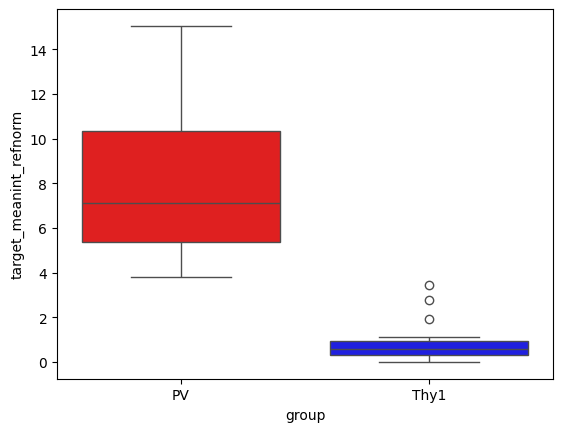

In [171]:
sns.boxplot(data_a4_ca1, y="target_meanint_refnorm", x="group",palette=['red','blue'])
plt.savefig('./boxplots/CA1_GluA4_meanint_refnorm_fovnorm_boxplot_allgroups.png',dpi=300)

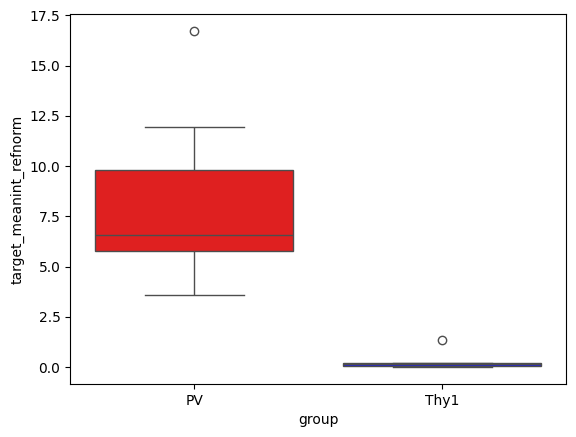

In [172]:
data_a4_ssc = data_norm_mean[(data_norm_mean['region']=='SSC')&(data_norm_mean['prot']=='GluA4')]
sns.boxplot(data_a4_ssc, y="target_meanint_refnorm", x="group",palette=['red','blue'])
plt.savefig('./boxplots/SSC_GluA4_meanint_refnorm_fovnorm_boxplot_allgroups.png',dpi=300)

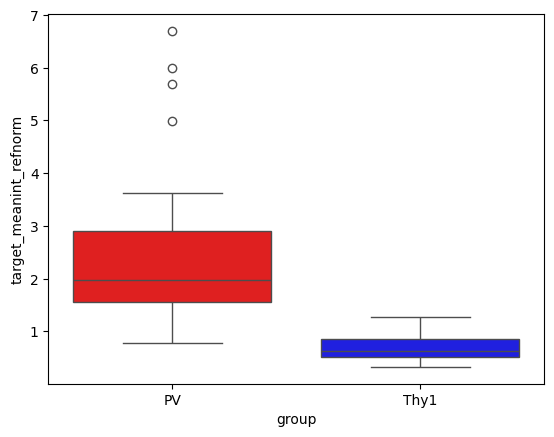

In [173]:
data_a1_ca1 = data_norm_mean[(data_norm_mean['region']=='CA1')&(data_norm_mean['prot']=='GluA1')]
sns.boxplot(data_a1_ca1, y="target_meanint_refnorm", x="group",order=['PV','Thy1'],palette=['red','blue'])
plt.savefig('./boxplots/CA1_GluA1_meanint_refnorm_fovnorm_boxplot_allgroups.png',dpi=300)

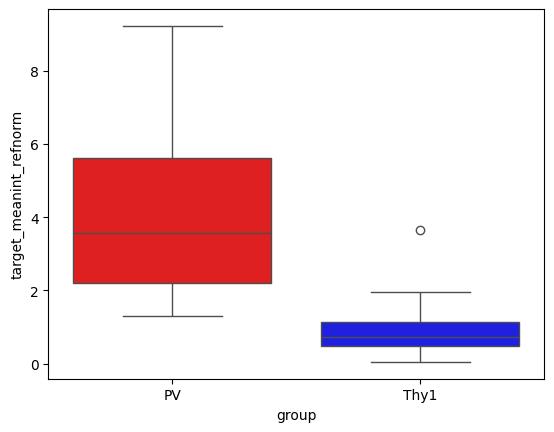

In [174]:
data_a1_ssc = data_norm_mean[(data_norm_mean['region']=='SSC')&(data_norm_mean['prot']=='GluA1')]
sns.boxplot(data_a1_ssc, y="target_meanint_refnorm", x="group",palette=['red','blue'])
plt.savefig('./boxplots/SSC_GluA1_meanint_refnorm_fovnorm_boxplot_allgroups.png',dpi=300)

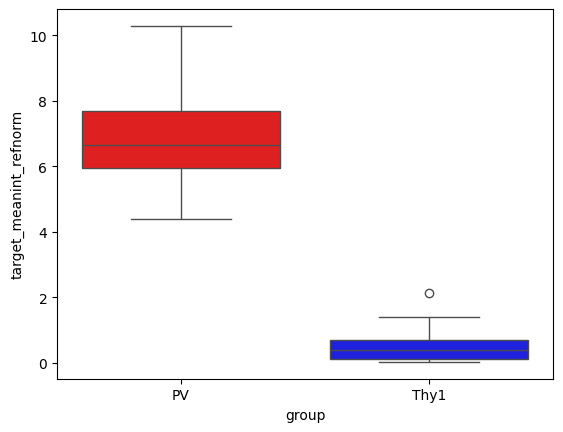

In [175]:
data_stg_ca1 = data_norm_mean[(data_norm_mean['region']=='CA1')&(data_norm_mean['prot']=='Stg')]
sns.boxplot(data_stg_ca1, y="target_meanint_refnorm", x="group",palette=['red','blue'])
plt.savefig('./boxplots/CA1_Stg_meanint_refnorm_fovnorm_boxplot_allgroups.png',dpi=300)

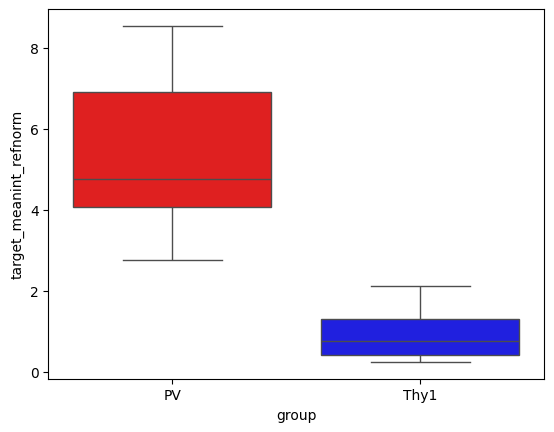

In [176]:
data_stg_ssc = data_norm_mean[(data_norm_mean['region']=='SSC')&(data_norm_mean['prot']=='Stg')]
sns.boxplot(data_stg_ssc, y="target_meanint_refnorm", x="group",palette=['red','blue'])
plt.savefig('./boxplots/SSC_Stg_meanint_refnorm_fovnorm_boxplot_allgroups.png',dpi=300)

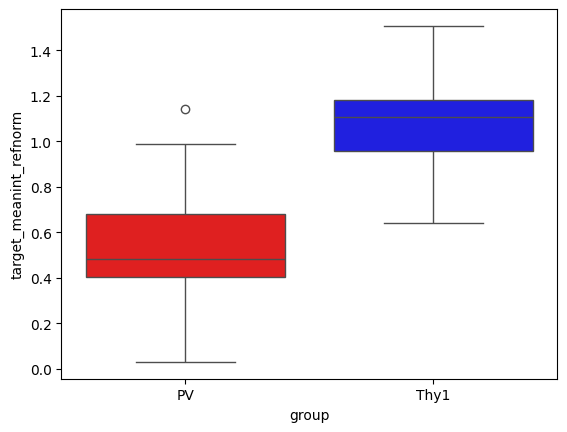

In [177]:
data_95_ca1 = data_norm_mean[(data_norm_mean['region']=='CA1')&(data_norm_mean['prot']=='PSD95')]
sns.boxplot(data_95_ca1, y="target_meanint_refnorm", x="group",order=['PV','Thy1'],palette=['red','blue'])
plt.savefig('./boxplots/CA1_PSD95_meanint_refnorm_fovnorm_boxplot_allgroups.png',dpi=300)

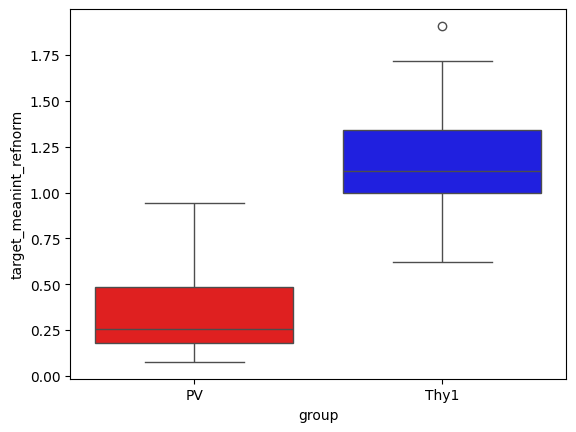

In [178]:
data_95_ssc = data_norm_mean[(data_norm_mean['region']=='SSC')&(data_norm_mean['prot']=='PSD95')]
sns.boxplot(data_95_ssc, y="target_meanint_refnorm", x="group",order=['PV','Thy1'],palette=['red','blue'])
plt.savefig('./boxplots/SSC_PSD95_meanint_refnorm_fovnorm_boxplot_allgroups.png',dpi=300)

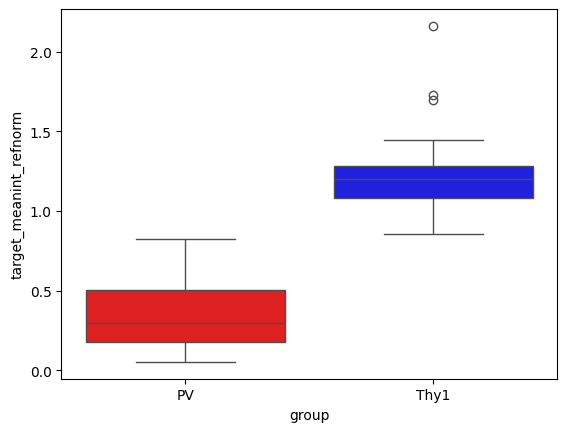

In [179]:
data_nr1_ca1 = data_norm_mean[(data_norm_mean['region']=='CA1')&(data_norm_mean['prot']=='NR1')]
sns.boxplot(data_nr1_ca1, y="target_meanint_refnorm", x="group",order=['PV','Thy1'],palette=['red','blue'])
plt.savefig('./boxplots/CA1_NR1_meanint_refnorm_fovnorm_boxplot_allgroups.png',dpi=300)

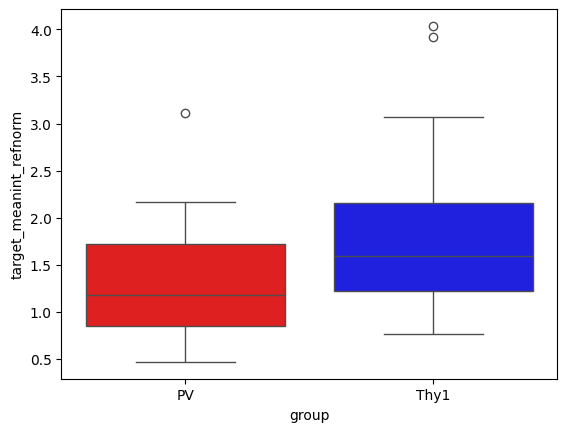

In [180]:
data_nr1_ssc = data_norm_mean[(data_norm_mean['region']=='SSC')&(data_norm_mean['prot']=='NR1')]
sns.boxplot(data_nr1_ssc, y="target_meanint_refnorm", x="group",order=['PV','Thy1'],palette=['red','blue'])
plt.savefig('./boxplots/SSC_NR1_meanint_refnorm_fovnorm_boxplot_allgroups.png',dpi=300)

### Run statistical tests on this within fov-normalized data

In [181]:
unadjusted_pvals = []
zscores = []

In [182]:
data_ctx = data_norm_mean[(data_norm_mean['region']=='SSC')]

In [183]:
data_ctx['group'].value_counts()

group
PV      84
Thy1    81
Name: count, dtype: int64

In [184]:
data_ctx['region'].value_counts()

region
SSC    165
Name: count, dtype: int64

In [185]:
data_ctx['prot'].value_counts()

prot
GluA1    48
Stg      31
GluA4    30
NR1      28
PSD95    28
Name: count, dtype: int64

#### 1. GluA4

In [186]:
data_ctx_a4 = data_ctx[data_ctx['prot']=='GluA4']

<Axes: ylabel='target_vol'>

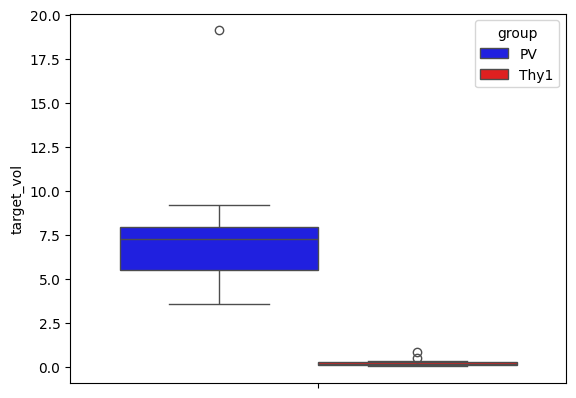

In [187]:
sns.boxplot(data_ctx_a4, y="target_vol", hue="group",palette=['blue','red'])

In [188]:
# Run mixed lm for target
md = smf.mixedlm("target_vol ~ group", data_ctx_a4, groups=data_ctx_a4["sample"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: target_vol
No. Observations: 30      Method:             REML      
No. Groups:       5       Scale:              6.3191    
Min. group size:  4       Log-Likelihood:     -69.3244  
Max. group size:  8       Converged:          Yes       
Mean group size:  6.0                                   
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      7.157    0.900  7.948 0.000  5.392  8.922
group[T.Thy1] -6.943    1.360 -5.104 0.000 -9.609 -4.277
Group Var      1.167    0.766                           



In [189]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

1.8915420142921385e-15
3.332508276270672e-07


In [190]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("target_meanint_refnorm ~ group", data_ctx_a4, groups=data_ctx_a4["sample"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: target_meanint_refnorm
No. Observations: 30      Method:             REML                  
No. Groups:       5       Scale:              5.0648                
Min. group size:  4       Log-Likelihood:     -67.1031              
Max. group size:  8       Converged:          Yes                   
Mean group size:  6.0                                               
----------------------------------------------------------------------
                 Coef.    Std.Err.     z      P>|z|    [0.025   0.975]
----------------------------------------------------------------------
Intercept         7.459      1.066    6.996   0.000     5.369    9.548
group[T.Thy1]    -7.259      1.643   -4.418   0.000   -10.480   -4.039
Group Var         2.393      1.268                                    



In [191]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

2.6366535015439303e-12
9.97200706376625e-06


#### 1. GluA1

In [192]:
data_ctx_a1 = data_ctx[data_ctx['prot']=='GluA1']

<Axes: ylabel='target_vol'>

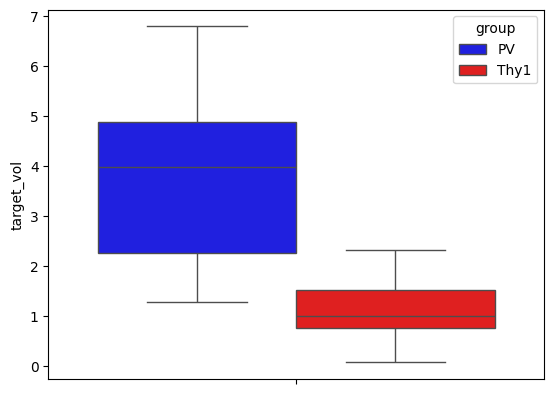

In [193]:
sns.boxplot(data_ctx_a1, y="target_vol", hue="group",palette=['blue','red'])

In [194]:
# Run mixed lm for target
md = smf.mixedlm("target_vol ~ group", data_ctx_a1, groups=data_ctx_a1["sample"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: target_vol
No. Observations: 48      Method:             REML      
No. Groups:       2       Scale:              1.4117    
Min. group size:  24      Log-Likelihood:     -76.3756  
Max. group size:  24      Converged:          Yes       
Mean group size:  24.0                                  
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      3.770    0.255 14.812 0.000  3.271  4.269
group[T.Thy1] -2.628    0.347 -7.567 0.000 -3.308 -1.947
Group Var      0.000    0.087                           



/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [195]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

1.2163425206522954e-49
3.8270397313702083e-14


In [196]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("target_meanint_refnorm ~ group", data_ctx_a1, groups=data_ctx_a1["sample"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: target_meanint_refnorm
No. Observations: 48      Method:             REML                  
No. Groups:       2       Scale:              2.3735                
Min. group size:  24      Log-Likelihood:     -88.3262              
Max. group size:  24      Converged:          Yes                   
Mean group size:  24.0                                              
----------------------------------------------------------------------
                  Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
----------------------------------------------------------------------
Intercept          4.070      0.328   12.395   0.000    3.427    4.714
group[T.Thy1]     -3.156      0.446   -7.075   0.000   -4.030   -2.282
Group Var          0.000                                              



/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [197]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

2.7824729245935123e-35
1.4943281655637713e-12


#### 3. Stg

In [198]:
data_ctx_stg = data_ctx[data_ctx['prot']=='Stg']

<Axes: ylabel='target_vol'>

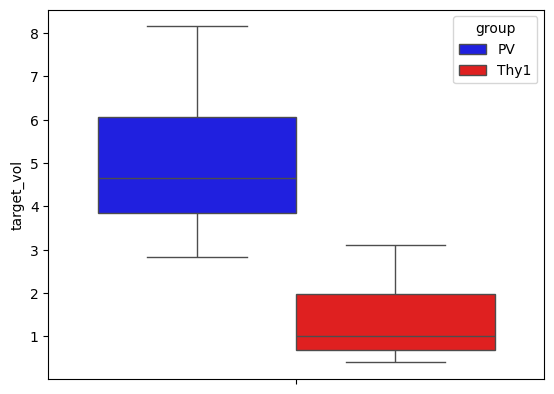

In [199]:
sns.boxplot(data_ctx_stg, y="target_vol", hue="group",palette=['blue','red'])

In [200]:
# Run mixed lm for target
md = smf.mixedlm("target_vol ~ group", data_ctx_stg, groups=data_ctx_stg["sample"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: target_vol
No. Observations: 31      Method:             REML      
No. Groups:       5       Scale:              1.7483    
Min. group size:  5       Log-Likelihood:     -51.9897  
Max. group size:  8       Converged:          Yes       
Mean group size:  6.2                                   
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      5.039    0.331 15.244 0.000  4.391  5.687
group[T.Thy1] -3.679    0.475 -7.741 0.000 -4.610 -2.747
Group Var      0.000                                    



/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [201]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

1.804781545370085e-52
9.838991454760962e-15


In [202]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("target_meanint_refnorm ~ group", data_ctx_stg, groups=data_ctx_stg["sample"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: target_meanint_refnorm
No. Observations: 31      Method:             REML                  
No. Groups:       5       Scale:              1.8636                
Min. group size:  5       Log-Likelihood:     -52.9164              
Max. group size:  8       Converged:          Yes                   
Mean group size:  6.2                                               
----------------------------------------------------------------------
                  Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
----------------------------------------------------------------------
Intercept          5.209      0.332   15.689   0.000    4.558    5.860
group[T.Thy1]     -4.250      0.484   -8.783   0.000   -5.198   -3.302
Group Var          0.000                                              



/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [203]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

1.8063465462449176e-55
1.5968377575358506e-18


#### 4. PSD95

In [204]:
data_ctx_95 = data_ctx[data_ctx['prot']=='PSD95']

<Axes: ylabel='target_vol'>

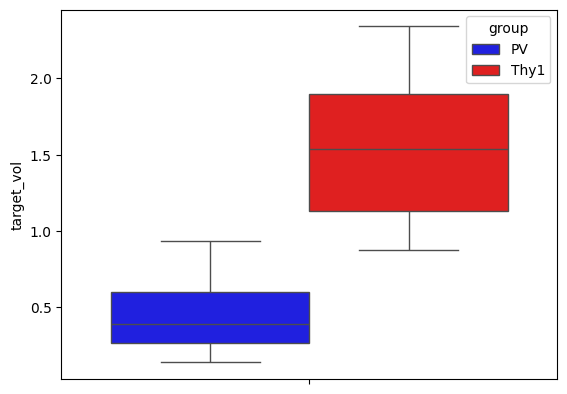

In [205]:
sns.boxplot(data_ctx_95, y="target_vol", hue="group",palette=['blue','red'])

In [206]:
# Run mixed lm for target
md = smf.mixedlm("target_vol ~ group", data_ctx_95, groups=data_ctx_95["sample"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: target_vol
No. Observations: 28      Method:             REML      
No. Groups:       5       Scale:              0.1233    
Min. group size:  4       Log-Likelihood:     -12.3662  
Max. group size:  7       Converged:          Yes       
Mean group size:  5.6                                   
--------------------------------------------------------
                Coef. Std.Err.   z   P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept       0.444    0.092 4.829 0.000  0.264  0.625
group[T.Thy1]   1.085    0.136 8.004 0.000  0.819  1.351
Group Var       0.001    0.057                          



In [207]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

1.3718158496703043e-06
1.2040683961166876e-15


In [208]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("target_meanint_refnorm ~ group", data_ctx_95, groups=data_ctx_95["sample"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: target_meanint_refnorm
No. Observations: 28      Method:             REML                  
No. Groups:       5       Scale:              0.0850                
Min. group size:  4       Log-Likelihood:     -8.5470               
Max. group size:  7       Converged:          Yes                   
Mean group size:  5.6                                               
----------------------------------------------------------------------
                    Coef.   Std.Err.     z     P>|z|   [0.025   0.975]
----------------------------------------------------------------------
Intercept           0.358      0.106   3.388   0.001    0.151    0.566
group[T.Thy1]       0.823      0.161   5.110   0.000    0.507    1.138
Group Var           0.016      0.100                                  



In [209]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

0.0007028822733391078
3.225277519145278e-07


#### 5. NR1

In [210]:
data_ctx_nr1 = data_ctx[data_ctx['prot']=='NR1']

In [211]:
data_ctx_nr1['group'].value_counts()

group
PV      15
Thy1    13
Name: count, dtype: int64

<Axes: ylabel='target_vol'>

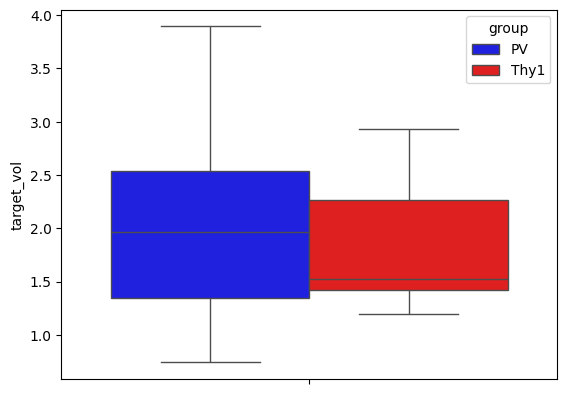

In [212]:
sns.boxplot(data_ctx_nr1, y="target_vol", hue="group",palette=['blue','red'])

In [213]:
# Run mixed lm for target
md = smf.mixedlm("target_vol ~ group", data_ctx_nr1, groups=data_ctx_nr1["sample"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: target_vol
No. Observations: 28      Method:             REML      
No. Groups:       5       Scale:              0.5844    
Min. group size:  4       Log-Likelihood:     -32.5450  
Max. group size:  8       Converged:          Yes       
Mean group size:  5.6                                   
--------------------------------------------------------
                Coef. Std.Err.   z   P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept       2.000    0.203 9.841 0.000  1.602  2.398
group[T.Thy1]   0.000    0.341 0.000 1.000 -0.669  0.669
Group Var       0.000    0.129                          



/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [214]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

7.478562066447405e-23
1.0


In [215]:
data_ctx_nr1

,target_vol,target_meanint,target_meanint_refnorm,region,sample,group,prot
roi_full,,,,,,,
PV-SSC-32-2-8-NR1-fov40x020,1.265722,1.089843,1.150916,SSC,32-2-8,PV,NR1
PV-SSC-32-2-8-NR1-fov40x022,1.963595,1.051783,0.877174,SSC,32-2-8,PV,NR1
PV-SSC-32-2-8-NR1-fov40x025,2.823412,1.237848,1.613021,SSC,32-2-8,PV,NR1
PV-SSC-32-2-8-NR1-fov40x028,1.724625,1.105675,1.122592,SSC,32-2-8,PV,NR1
PV-SSC-33-1-7-NR1-fov40x029,1.228340,1.025534,0.821895,SSC,33-1-7,PV,NR1
PV-SSC-33-1-7-NR1-fov40x032,1.367834,0.899542,0.727762,SSC,33-1-7,PV,NR1
PV-SSC-33-1-7-NR1-fov40x033,1.498735,1.095577,1.174300,SSC,33-1-7,PV,NR1
PV-SSC-33-1-7-NR1-fov40x035,3.895365,1.415525,3.112653,SSC,33-1-7,PV,NR1
PV-SSC-33-1-7-NR1-fov40x037,0.741477,0.936276,0.468813,SSC,33-1-7,PV,NR1


In [216]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("target_meanint_refnorm ~ group", data_ctx_nr1, groups=data_ctx_nr1["sample"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: target_meanint_refnorm
No. Observations: 28      Method:             REML                  
No. Groups:       5       Scale:              0.8037                
Min. group size:  4       Log-Likelihood:     -36.7602              
Max. group size:  8       Converged:          Yes                   
Mean group size:  5.6                                               
----------------------------------------------------------------------
                    Coef.   Std.Err.     z     P>|z|   [0.025   0.975]
----------------------------------------------------------------------
Intercept           1.377      0.238   5.784   0.000    0.910    1.843
group[T.Thy1]       0.518      0.354   1.466   0.143   -0.175    1.212
Group Var           0.007      0.163                                  



/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [217]:
for x in range (0, 2):
    print(mdf.pvalues[x])
#unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later
unadjusted_pvals.append(1) #hard coded this for now to avoid nan

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

7.306580783710372e-09
0.14258419459630048


In [218]:
# #from ChatGPT 4.0 about the above issue on 9/6/24:
# The issue with the nan p-value for your coefficient of interest (group[T.Thy1]) in the mixed linear model is likely due to the fact that the estimated coefficient is exactly zero (0.000), with no associated standard error (Std.Err. is not reported), which can lead to numerical problems when calculating the test statistics (such as z-scores) and p-values.

# Here are some possible reasons why this is happening:

# Perfect Collinearity or Redundancy: The group variable might be perfectly collinear with the intercept, meaning the model cannot distinguish the effect of group[T.Thy1] from the intercept. This often happens when you have categorical variables that aren't properly coded (e.g., missing reference levels, perfect separation).

# Lack of Variation: If all or most observations in the group[T.Thy1] group have the same values for the dependent variable (target_meanint_refnorm), the model might not be able to estimate a meaningful effect size, resulting in a coefficient of zero and undefined standard errors.

# Model Specification Issue: The problem could arise from how the model is specified. Ensure that group is correctly interpreted as a categorical variable by the model. Also, double-check that there are no missing data points or coding errors.

# Numerical Optimization Problems: Sometimes, issues can arise from the numerical optimization methods used to fit the model, especially if the variance components (Group Var) are estimated as zero or near-zero.

# Here are steps you can take to troubleshoot and resolve the issue:

# Check for Collinearity: Inspect your data for collinearity between the intercept and the group variable. Make sure that group has multiple levels with enough variation.

# Verify Group Coding: Ensure that the group variable is correctly treated as a categorical variable, especially if it was manually encoded.

# Inspect Data Distribution: Check if there are any data distribution issues, such as all values being identical or missing for certain groups.

# Change Reference Group: Try changing the reference group in your categorical variable to see if the issue persists.

# Re-specify the Model: Consider re-specifying the model or fitting a simpler model to check if the nan issue persists.

# If the issue persists after these checks, it may also help to use a different fitting method or optimizer to see if it handles the estimation better, or add more data if the group sizes are too small to estimate variances reliably.

#### Compile and correct p-values

In [219]:
pvals_df_index = [
    'GluA4_vol',
    'GluA4_meanint_refnorm',
    'GluA1_vol',
    'GluA1_meanint_refnorm',
            'Stg_vol',
    'Stg_meanint_refnorm',
        'PSD95_vol',
    'PSD95_meanint_refnorm',
        'NR1_vol',
    'NR1_meanint_refnorm'
]

In [220]:
pvals_df = pd.DataFrame(unadjusted_pvals,index=pvals_df_index,columns=['p_unadjusted'])

In [221]:
pvals_df['zscore_unselected'] = zscores

In [222]:
pvals_df['p_adjusted'] = stats.false_discovery_control(pvals_df['p_unadjusted'])
pvals_df['significant'] = pvals_df['p_adjusted'] < 0.05
pvals_df.to_csv('ssc_fovmean_selectedvsunselected_lmer_pvals.csv')

In [223]:
prots = unique(data['prot'])
values = ['target_vol','target_meanint_refnorm']
group_colors = ['blue','red']

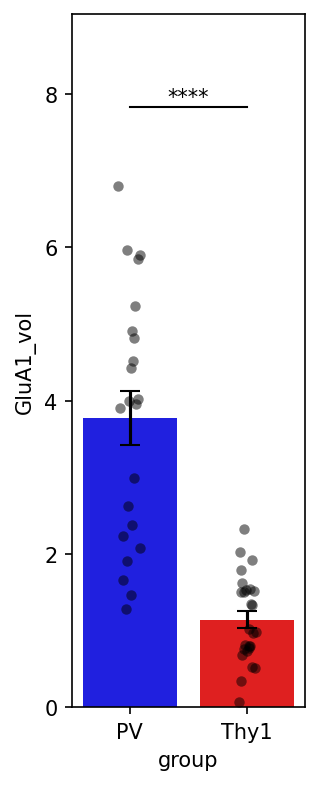

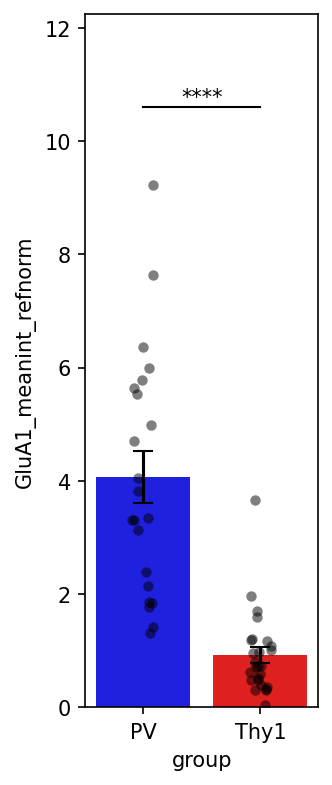

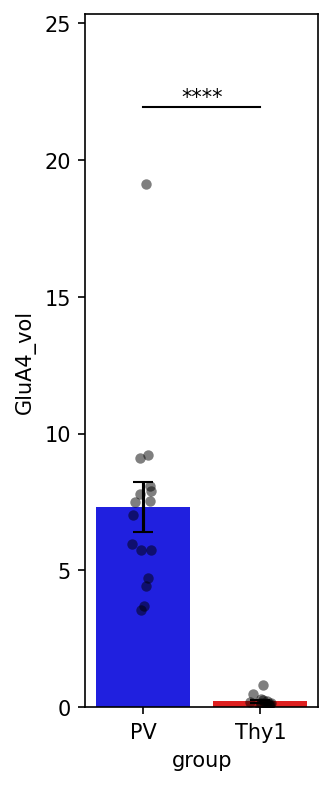

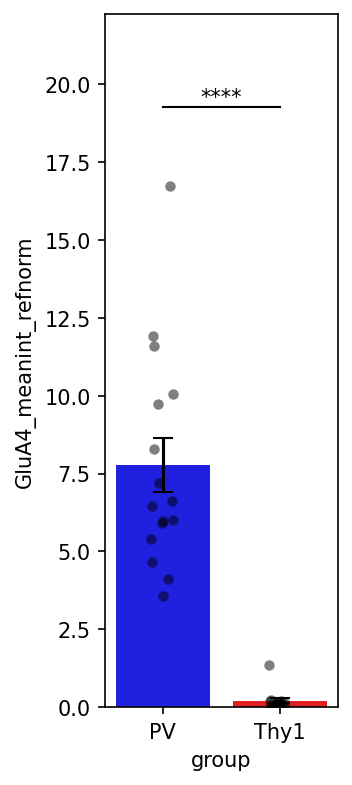

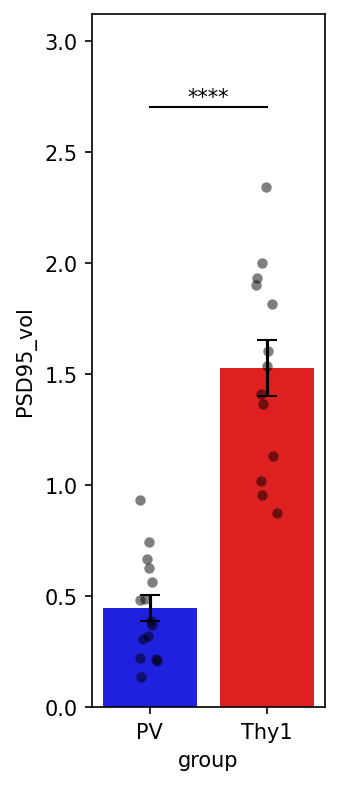

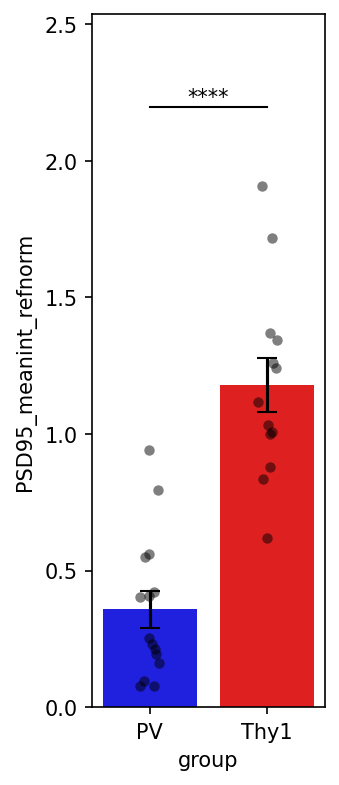

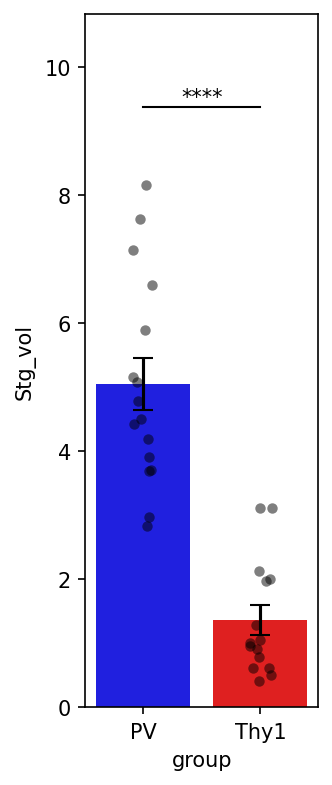

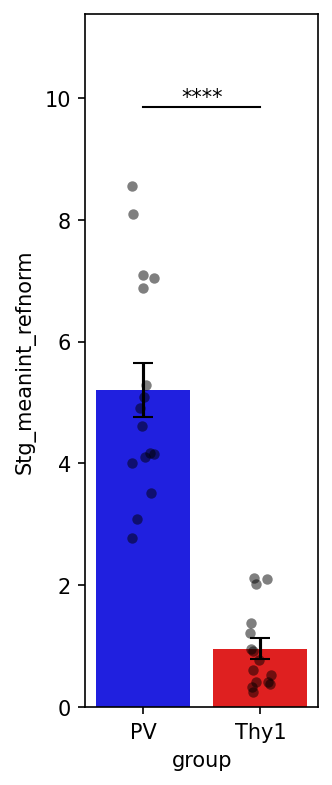

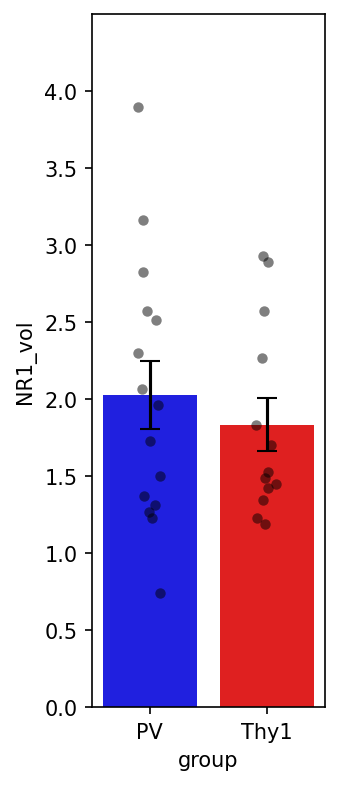

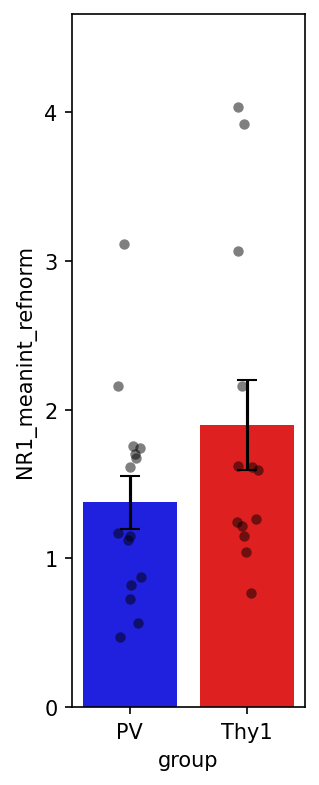

In [224]:
# Code generated by ChatGPT (4.0) on 6/9/24 by MES, also modified by MES

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Assuming your data_ctxFrame with data_ctx is named 'data_ctx'
# and the data frame with significance information is named 'pvals_df'
# pvals_df should have an index matching the numerical variable names in 'data_ctx'

# Example data_ctxFrames (uncomment and adjust according to your actual data_ctx)
# data_ctx = pd.read_csv('your_data_ctx.csv')
# pvals_df = pd.read_csv('your_significance_data_ctx.csv')

# Identify numerical columns in 'data_ctx'
numerical_columns = data_ctx.select_dtypes(include='number').columns

# Get unique values of 'group'
types = data_ctx['group'].unique()

# Function to calculate SEM
def sem(x):
    return stats.sem(x, nan_policy='omit')

# Function to determine the number of asterisks based on p-value
def get_significance_asterisks(p_value):
    if p_value < 0.0001:
        return '****'
    elif p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return ''

# Create bar plots for each numerical variable
for prot in prots:
    for col in values:
        data_temp = data_ctx[data_ctx['prot']==prot]
        plt.figure(figsize=(2,6),dpi=150)
        ax = sns.barplot(x='group', y=col, data=data_temp, ci=None, palette=group_colors)  # Suppress default error bars
        
        # Add individual data_ctx points
        sns.stripplot(x='group', y=col, data=data_temp, color='black', size=5, jitter=True, ax=ax, alpha = 0.5)
        
        # Calculate and plot error bars (mean ± SEM)
        means = data_temp.groupby('group')[col].mean()
        sems = data_temp.groupby('group')[col].apply(sem)
        for i, type_val in enumerate(types):
           plt.errorbar(i, means[type_val], yerr=sems[type_val], fmt='none', c='black', capsize=5)
    
        # Add significance asterisks if applicable
        if len(col.split("_")) > 2:
            value_name = prot + '_' + col.split("_")[1] + '_' + col.split("_")[2]
        else:
            value_name = prot + '_' + col.split("_")[1]
        
        if value_name in pvals_df.index and pvals_df.loc[value_name, 'significant'] == True:
            p_value = pvals_df.loc[value_name, 'p_adjusted']
            asterisks = get_significance_asterisks(p_value)
            if asterisks:
                max_y = data_temp[col].max()
                # Position the asterisks above the highest data_temp point
                y = max_y + sems.max() + 0.1 * max_y
                plt.plot([0, 1], [y, y], color='black', lw=1)  # horizontal line
                plt.text(0.5, y, asterisks, ha='center', va='bottom', color='black')
    
        # Adjust y-axis to add space for asterisks
        current_ylim = plt.ylim()
        plt.ylim(current_ylim[0], current_ylim[1] * 1.1)
    
        plt.grid(False) #remove gridlines
        
        # Set plot title and labels
        # plt.title(f'Bar Plot for {col}')
        #plt.xlabel('Group')
        plt.ylabel(value_name)
    
        # Save plot
        plt.savefig(parentdir + '/SSC_fovmean_barplots/' + col + '_' + prot + '.svg',dpi=800,bbox_inches='tight')
        plt.savefig(parentdir + '/SSC_fovmean_barplots/' + col + '_' + prot + '.png',dpi=800,bbox_inches='tight')
        
        # Show plot
        plt.show()

### Now repeat for CA1

In [225]:
unadjusted_pvals = []
zscores = []

In [226]:
data_ca1 = data_norm_mean[(data_norm_mean['region']=='CA1')]

In [227]:
data_ca1['group'].value_counts()

group
Thy1    99
PV      81
Name: count, dtype: int64

In [228]:
data_ca1['region'].value_counts()

region
CA1    180
Name: count, dtype: int64

In [229]:
data_ca1['prot'].value_counts()

prot
GluA1    45
GluA4    34
NR1      34
PSD95    34
Stg      33
Name: count, dtype: int64

#### 1. GluA4

In [230]:
data_ca1_a4 = data_ca1[data_ca1['prot']=='GluA4']

<Axes: ylabel='target_vol'>

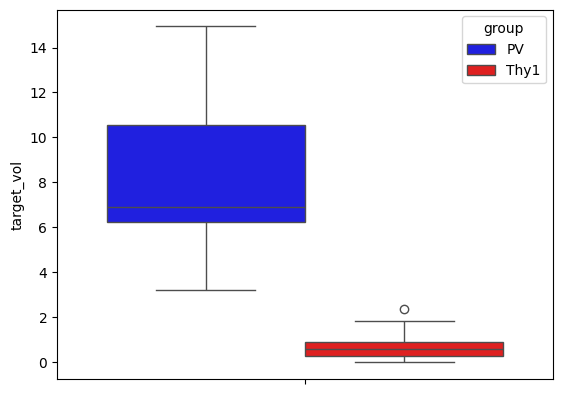

In [231]:
sns.boxplot(data_ca1_a4, y="target_vol", hue="group",palette=['blue','red'])

In [232]:
# Run mixed lm for target
md = smf.mixedlm("target_vol ~ group", data_ca1_a4, groups=data_ca1_a4["sample"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

          Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: target_vol
No. Observations:  34      Method:             REML      
No. Groups:        5       Scale:              3.1021    
Min. group size:   4       Log-Likelihood:     -69.4708  
Max. group size:   10      Converged:          Yes       
Mean group size:   6.8                                   
---------------------------------------------------------
              Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------
Intercept      8.483    1.182  7.179 0.000   6.167 10.799
group[T.Thy1] -7.774    1.826 -4.257 0.000 -11.354 -4.194
Group Var      3.552    2.007                            



In [233]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

7.027196680498256e-13
2.0764224474771948e-05


In [234]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("target_meanint_refnorm ~ group", data_ca1_a4, groups=data_ca1_a4["sample"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: target_meanint_refnorm
No. Observations: 34      Method:             REML                  
No. Groups:       5       Scale:              3.9472                
Min. group size:  4       Log-Likelihood:     -72.8562              
Max. group size:  10      Converged:          Yes                   
Mean group size:  6.8                                               
----------------------------------------------------------------------
                 Coef.    Std.Err.     z      P>|z|    [0.025   0.975]
----------------------------------------------------------------------
Intercept         8.353      1.145    7.295   0.000     6.109   10.597
group[T.Thy1]    -7.508      1.755   -4.277   0.000   -10.949   -4.067
Group Var         3.125      1.666                                    



In [235]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

2.9835350292627535e-13
1.8945371706954125e-05


#### 1. GluA1

In [236]:
data_ca1_a1 = data_ca1[data_ca1['prot']=='GluA1']

<Axes: ylabel='target_vol'>

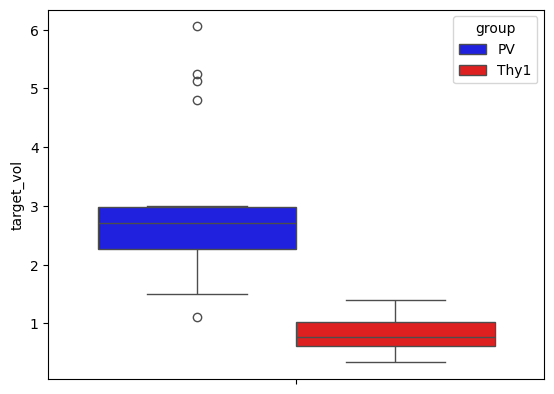

In [237]:
sns.boxplot(data_ca1_a1, y="target_vol", hue="group",palette=['blue','red'])

In [238]:
# Run mixed lm for target
md = smf.mixedlm("target_vol ~ group", data_ca1_a1, groups=data_ca1_a1["sample"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: target_vol
No. Observations: 45      Method:             REML      
No. Groups:       2       Scale:              0.7758    
Min. group size:  22      Log-Likelihood:     -59.1373  
Max. group size:  23      Converged:          Yes       
Mean group size:  22.5                                  
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      2.965    0.258 11.511 0.000  2.460  3.470
group[T.Thy1] -2.126    0.265 -8.019 0.000 -2.646 -1.607
Group Var      0.055    0.145                           



In [239]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

1.167798825898286e-30
1.0662408833050197e-15


In [240]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("target_meanint_refnorm ~ group", data_ca1_a1, groups=data_ca1_a1["sample"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: target_meanint_refnorm
No. Observations: 45      Method:             REML                  
No. Groups:       2       Scale:              1.2748                
Min. group size:  22      Log-Likelihood:     -70.1697              
Max. group size:  23      Converged:          Yes                   
Mean group size:  22.5                                              
----------------------------------------------------------------------
                  Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
----------------------------------------------------------------------
Intercept          2.630      0.430    6.120   0.000    1.788    3.473
group[T.Thy1]     -1.903      0.340   -5.601   0.000   -2.568   -1.237
Group Var          0.241      0.378                                   



In [241]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

9.3428963167199e-10
2.135900541797785e-08


#### 3. Stg

In [242]:
data_ca1_stg = data_ca1[data_ca1['prot']=='Stg']

<Axes: ylabel='target_vol'>

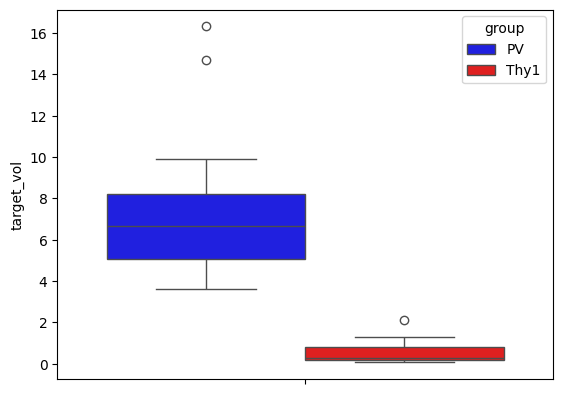

In [243]:
sns.boxplot(data_ca1_stg, y="target_vol", hue="group",palette=['blue','red'])

In [244]:
# Run mixed lm for target
md = smf.mixedlm("target_vol ~ group", data_ca1_stg, groups=data_ca1_stg["sample"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

          Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: target_vol
No. Observations:  33      Method:             REML      
No. Groups:        5       Scale:              4.8831    
Min. group size:   5       Log-Likelihood:     -73.7957  
Max. group size:   10      Converged:          Yes       
Mean group size:   6.6                                   
---------------------------------------------------------
              Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------
Intercept      7.477    1.172  6.381 0.000   5.180  9.774
group[T.Thy1] -6.962    1.808 -3.851 0.000 -10.505 -3.419
Group Var      3.198    1.622                            



In [245]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

1.7643288583790903e-10
0.00011740806003938244


In [246]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("target_meanint_refnorm ~ group", data_ca1_stg, groups=data_ca1_stg["sample"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: target_meanint_refnorm
No. Observations: 33      Method:             REML                  
No. Groups:       5       Scale:              1.4452                
Min. group size:  5       Log-Likelihood:     -53.6761              
Max. group size:  10      Converged:          No                    
Mean group size:  6.6                                               
----------------------------------------------------------------------
                 Coef.    Std.Err.      z      P>|z|   [0.025   0.975]
----------------------------------------------------------------------
Intercept         6.957      0.429    16.227   0.000    6.117    7.797
group[T.Thy1]    -6.424      0.641   -10.027   0.000   -7.680   -5.169
Group Var         0.278      0.631                                    



/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.989413
  warnings.warn(msg, ConvergenceWarning)


In [247]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

3.223896810537076e-59
1.1632890187038674e-23


#### 4. PSD95

In [248]:
data_ca1_95 = data_ca1[data_ca1['prot']=='PSD95']

<Axes: ylabel='target_vol'>

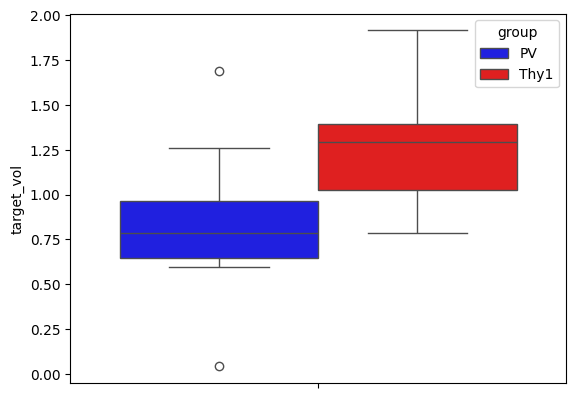

In [249]:
sns.boxplot(data_ca1_95, y="target_vol", hue="group",palette=['blue','red'])

In [250]:
# Run mixed lm for target
md = smf.mixedlm("target_vol ~ group", data_ca1_95, groups=data_ca1_95["sample"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: target_vol
No. Observations: 34      Method:             REML      
No. Groups:       5       Scale:              0.0944    
Min. group size:  4       Log-Likelihood:     -11.5336  
Max. group size:  10      Converged:          Yes       
Mean group size:  6.8                                   
--------------------------------------------------------
                Coef. Std.Err.   z   P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept       0.826    0.108 7.630 0.000  0.614  1.039
group[T.Thy1]   0.407    0.156 2.606 0.009  0.101  0.713
Group Var       0.015    0.096                          



In [251]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

2.345174554814854e-14
0.009169235156035028


In [252]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("target_meanint_refnorm ~ group", data_ca1_95, groups=data_ca1_95["sample"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: target_meanint_refnorm
No. Observations: 34      Method:             REML                  
No. Groups:       5       Scale:              0.0525                
Min. group size:  4       Log-Likelihood:     -2.7057               
Max. group size:  10      Converged:          Yes                   
Mean group size:  6.8                                               
----------------------------------------------------------------------
                    Coef.   Std.Err.     z     P>|z|   [0.025   0.975]
----------------------------------------------------------------------
Intercept           0.541      0.095   5.677   0.000    0.354    0.727
group[T.Thy1]       0.547      0.141   3.866   0.000    0.270    0.824
Group Var           0.016      0.098                                  



In [253]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

1.3693380335419527e-08
0.00011061975321835777


#### 5. NR1

In [254]:
data_ca1_nr1 = data_ca1[data_ca1['prot']=='NR1']

In [255]:
data_ca1_nr1['group'].value_counts()

group
Thy1    19
PV      15
Name: count, dtype: int64

<Axes: ylabel='target_vol'>

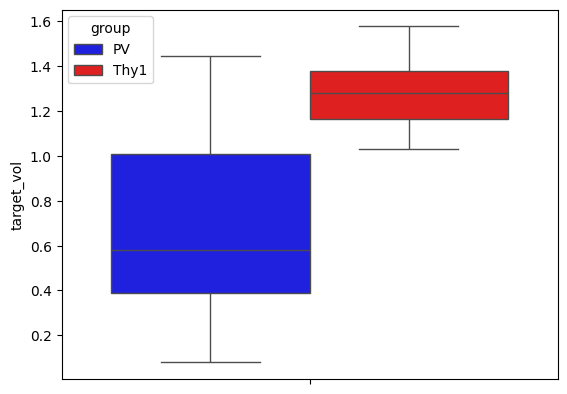

In [256]:
sns.boxplot(data_ca1_nr1, y="target_vol", hue="group",palette=['blue','red'])

In [257]:
# Run mixed lm for target
md = smf.mixedlm("target_vol ~ group", data_ca1_nr1, groups=data_ca1_nr1["sample"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: target_vol
No. Observations: 34      Method:             REML      
No. Groups:       5       Scale:              0.0838    
Min. group size:  4       Log-Likelihood:     -8.5635   
Max. group size:  10      Converged:          No        
Mean group size:  6.8                                   
--------------------------------------------------------
                Coef. Std.Err.   z   P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept       0.668    0.074 9.021 0.000  0.523  0.813
group[T.Thy1]   0.618    0.099 6.234 0.000  0.424  0.813
Group Var       0.000                                   



/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.064445
  warnings.warn(msg, ConvergenceWarning)
/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/margaret/miniconda3/

In [258]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

1.8641854328291888e-19
4.537345013242205e-10


In [259]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("target_meanint_refnorm ~ group", data_ca1_nr1, groups=data_ca1_nr1["sample"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: target_meanint_refnorm
No. Observations: 34      Method:             REML                  
No. Groups:       5       Scale:              0.0821                
Min. group size:  4       Log-Likelihood:     -8.2314               
Max. group size:  10      Converged:          Yes                   
Mean group size:  6.8                                               
----------------------------------------------------------------------
                    Coef.   Std.Err.     z     P>|z|   [0.025   0.975]
----------------------------------------------------------------------
Intercept           0.362      0.074   4.888   0.000    0.217    0.507
group[T.Thy1]       0.901      0.099   9.107   0.000    0.707    1.095
Group Var           0.000                                             



/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [260]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later
#unadjusted_pvals.append(1) #hard coded this for now to avoid nan

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

1.0184053280279658e-06
8.438939454028254e-20


In [261]:
#zscores.append(0)

In [262]:
# #from ChatGPT 4.0 about the above issue on 9/6/24:
# The issue with the nan p-value for your coefficient of interest (group[T.Thy1]) in the mixed linear model is likely due to the fact that the estimated coefficient is exactly zero (0.000), with no associated standard error (Std.Err. is not reported), which can lead to numerical problems when calculating the test statistics (such as z-scores) and p-values.

# Here are some possible reasons why this is happening:

# Perfect Collinearity or Redundancy: The group variable might be perfectly collinear with the intercept, meaning the model cannot distinguish the effect of group[T.Thy1] from the intercept. This often happens when you have categorical variables that aren't properly coded (e.g., missing reference levels, perfect separation).

# Lack of Variation: If all or most observations in the group[T.Thy1] group have the same values for the dependent variable (target_meanint_refnorm), the model might not be able to estimate a meaningful effect size, resulting in a coefficient of zero and undefined standard errors.

# Model Specification Issue: The problem could arise from how the model is specified. Ensure that group is correctly interpreted as a categorical variable by the model. Also, double-check that there are no missing data points or coding errors.

# Numerical Optimization Problems: Sometimes, issues can arise from the numerical optimization methods used to fit the model, especially if the variance components (Group Var) are estimated as zero or near-zero.

# Here are steps you can take to troubleshoot and resolve the issue:

# Check for Collinearity: Inspect your data for collinearity between the intercept and the group variable. Make sure that group has multiple levels with enough variation.

# Verify Group Coding: Ensure that the group variable is correctly treated as a categorical variable, especially if it was manually encoded.

# Inspect Data Distribution: Check if there are any data distribution issues, such as all values being identical or missing for certain groups.

# Change Reference Group: Try changing the reference group in your categorical variable to see if the issue persists.

# Re-specify the Model: Consider re-specifying the model or fitting a simpler model to check if the nan issue persists.

# If the issue persists after these checks, it may also help to use a different fitting method or optimizer to see if it handles the estimation better, or add more data if the group sizes are too small to estimate variances reliably.

#### Compile and correct p-values

In [263]:
pvals_df_index = [
    'GluA4_vol',
    'GluA4_meanint_refnorm',
    'GluA1_vol',
    'GluA1_meanint_refnorm',
            'Stg_vol',
    'Stg_meanint_refnorm',
        'PSD95_vol',
    'PSD95_meanint_refnorm',
        'NR1_vol',
    'NR1_meanint_refnorm'
]

In [264]:
pvals_df = pd.DataFrame(unadjusted_pvals,index=pvals_df_index,columns=['p_unadjusted'])

In [265]:
pvals_df['zscore_unselected'] = zscores

In [266]:
pvals_df['p_adjusted'] = stats.false_discovery_control(pvals_df['p_unadjusted'])
pvals_df['significant'] = pvals_df['p_adjusted'] < 0.05
pvals_df.to_csv('ca1_fovmean_selectedvsunselected_lmer_pvals.csv')

In [267]:
prots = unique(data['prot'])
values = ['target_vol','target_meanint_refnorm']
group_colors = ['blue','red']

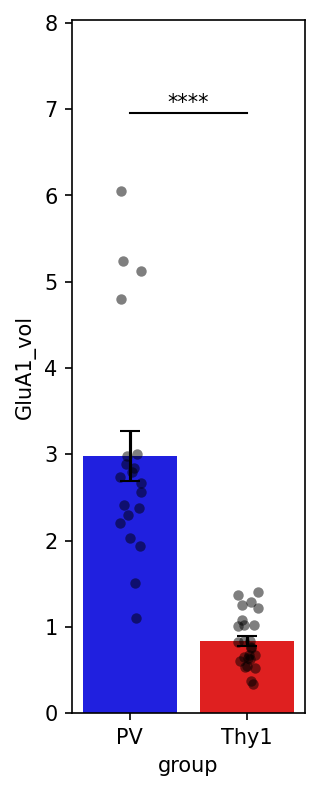

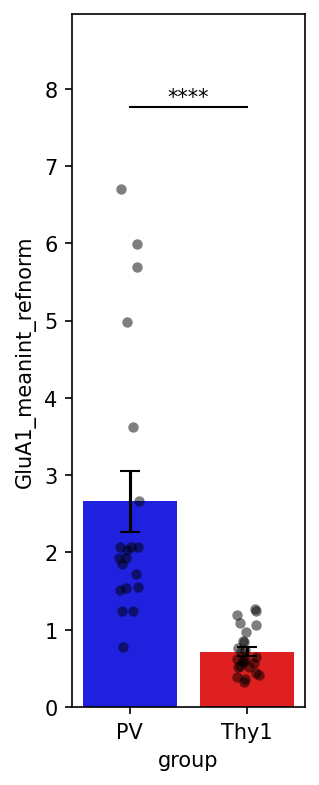

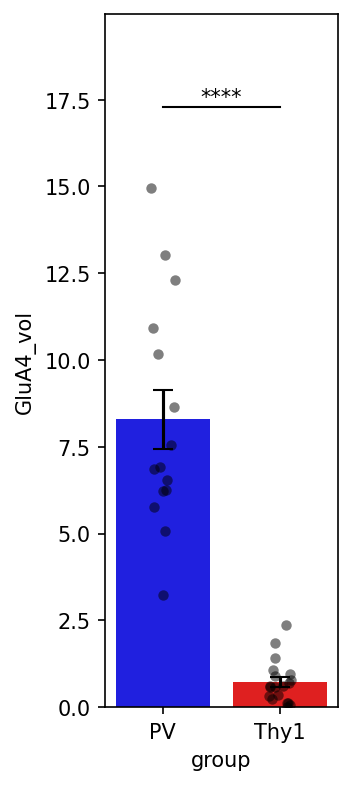

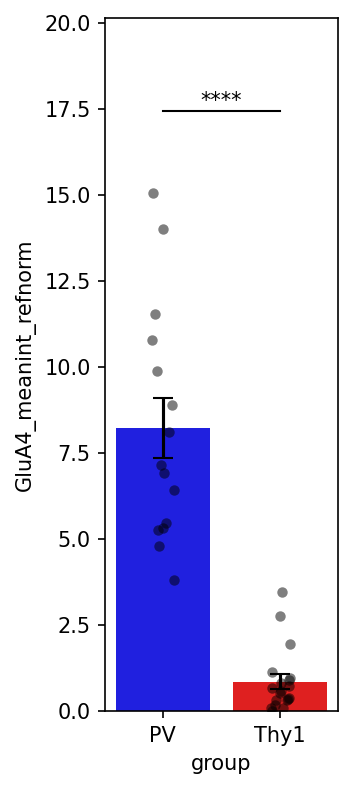

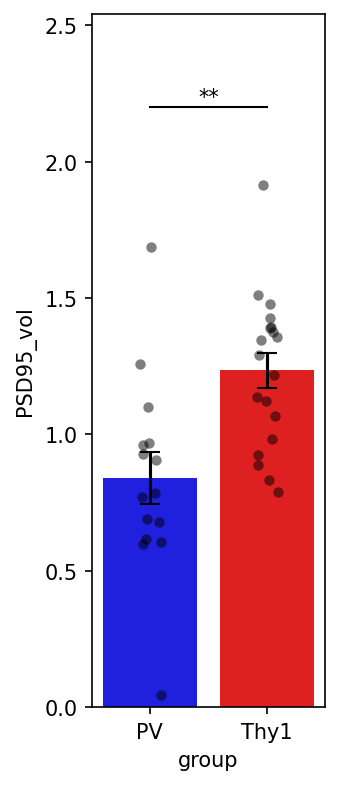

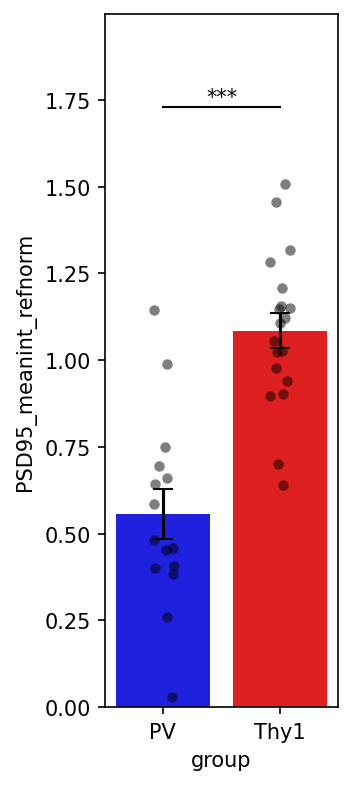

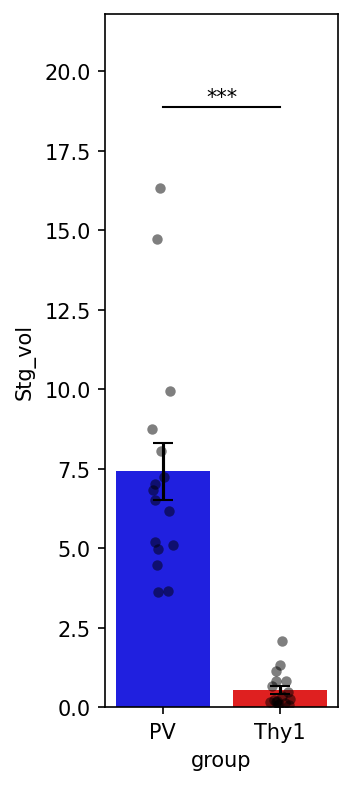

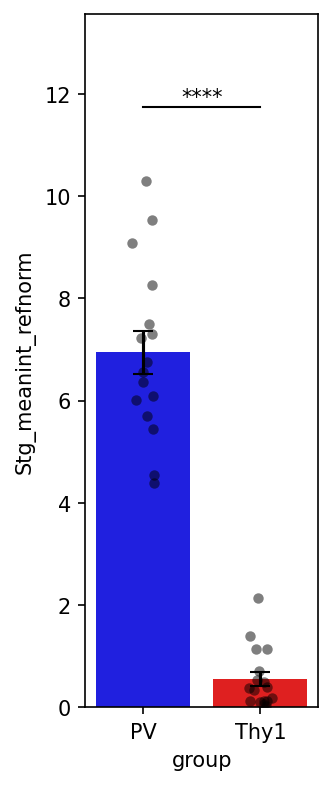

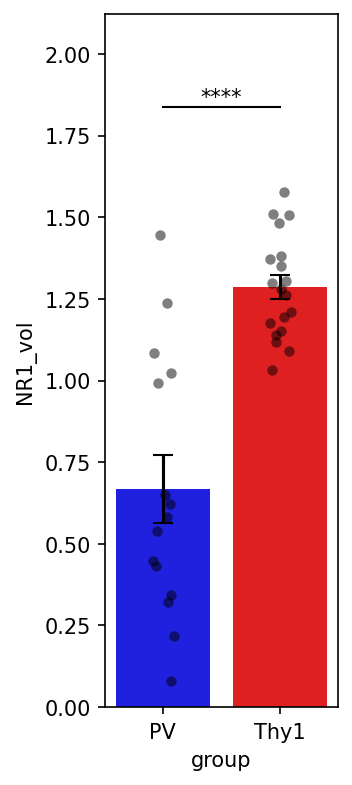

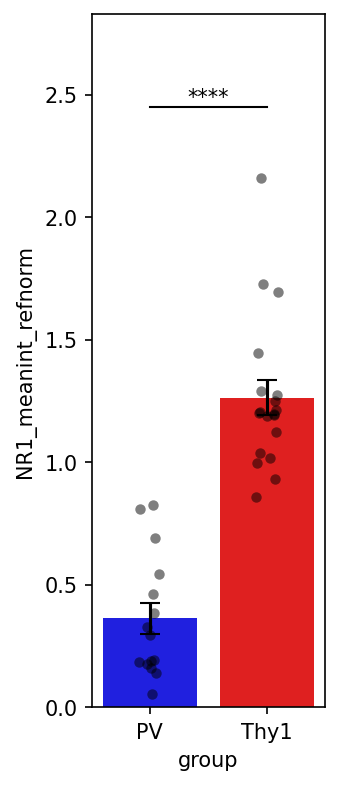

In [268]:
# Code generated by ChatGPT (4.0) on 6/9/24 by MES, also modified by MES

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Assuming your data_ctxFrame with data_ctx is named 'data_ctx'
# and the data frame with significance information is named 'pvals_df'
# pvals_df should have an index matching the numerical variable names in 'data_ctx'

# Example data_ctxFrames (uncomment and adjust according to your actual data_ctx)
# data_ctx = pd.read_csv('your_data_ctx.csv')
# pvals_df = pd.read_csv('your_significance_data_ctx.csv')

# Identify numerical columns in 'data_ctx'
numerical_columns = data_ca1.select_dtypes(include='number').columns

# Get unique values of 'group'
types = data_ca1['group'].unique()

# Function to calculate SEM
def sem(x):
    return stats.sem(x, nan_policy='omit')

# Function to determine the number of asterisks based on p-value
def get_significance_asterisks(p_value):
    if p_value < 0.0001:
        return '****'
    elif p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return ''

# Create bar plots for each numerical variable
for prot in prots:
    for col in values:
        data_temp = data_ca1[data_ca1['prot']==prot]
        plt.figure(figsize=(2,6),dpi=150)
        ax = sns.barplot(x='group', y=col, data=data_temp, ci=None, palette=group_colors)  # Suppress default error bars
        
        # Add individual data_ctx points
        sns.stripplot(x='group', y=col, data=data_temp, color='black', size=5, jitter=True, ax=ax, alpha = 0.5)
        
        # Calculate and plot error bars (mean ± SEM)
        means = data_temp.groupby('group')[col].mean()
        sems = data_temp.groupby('group')[col].apply(sem)
        for i, type_val in enumerate(types):
           plt.errorbar(i, means[type_val], yerr=sems[type_val], fmt='none', c='black', capsize=5)
    
        # Add significance asterisks if applicable
        if len(col.split("_")) > 2:
            value_name = prot + '_' + col.split("_")[1] + '_' + col.split("_")[2]
        else:
            value_name = prot + '_' + col.split("_")[1]
        
        if value_name in pvals_df.index and pvals_df.loc[value_name, 'significant'] == True:
            p_value = pvals_df.loc[value_name, 'p_adjusted']
            asterisks = get_significance_asterisks(p_value)
            if asterisks:
                max_y = data_temp[col].max()
                # Position the asterisks above the highest data_temp point
                y = max_y + sems.max() + 0.1 * max_y
                plt.plot([0, 1], [y, y], color='black', lw=1)  # horizontal line
                plt.text(0.5, y, asterisks, ha='center', va='bottom', color='black')
    
        # Adjust y-axis to add space for asterisks
        current_ylim = plt.ylim()
        plt.ylim(current_ylim[0], current_ylim[1] * 1.1)
    
        plt.grid(False) #remove gridlines
        
        # Set plot title and labels
        # plt.title(f'Bar Plot for {col}')
        #plt.xlabel('Group')
        plt.ylabel(value_name)
    
        # Save plot
        plt.savefig(parentdir + '/CA1_fovmean_barplots/' + col + '_' + prot + '.svg',dpi=800,bbox_inches='tight')
        plt.savefig(parentdir + '/CA1_fovmean_barplots/' + col + '_' + prot + '.png',dpi=800,bbox_inches='tight')
        
        # Show plot
        plt.show()

## What is the mean # of selected vs. unselected synapses?

In [269]:
data[['selected_tf','roi_full']].groupby('roi_full').mean().to_csv('Thy1_vs_PV_alldata_combined_fov_proportion_selected.csv')

In [270]:
data[['selected_tf','roi_full']].groupby('roi_full').mean().mean()

selected_tf    0.039637
dtype: float64